In [54]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from openTSNE import TSNE
from PIL import Image
import umap
import torch.nn.functional as F
from scipy.spatial.distance import cdist
import umap.plot
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import random
import joblib
from scipy.signal import savgol_filter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared

from core.final.dataset import PSMDataset
from core.final.model import GalSpecNet, MetaModel, Informer, AstroModel
from core.final.trainer import Trainer

In [2]:
def get_model(config):
    if config['mode'] == 'photo':
        model = Informer(config)
    elif config['mode'] == 'spectra':
        model = GalSpecNet(config)
    elif config['mode'] == 'meta':
        model = MetaModel(config)
    else:
        model = AstroModel(config)

    return model

In [3]:
def plot_one_embs(embeddings, targets):
    plt.figure(figsize=(10, 8))
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        plt.scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=1.0, s=marker_size)
        
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    plt.legend(handles=handles_colors, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [4]:
def plot_one_embs_period(embeddings, periods):
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=periods, cmap='viridis', s=marker_size, alpha=1.0)
    plt.colorbar(sc, label='Period log10')
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [5]:
def plot_one_embs_mask(embeddings, targets, outliers):
    plt.figure(figsize=(20, 16))
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        plt.scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=1.0, s=3 * marker_size)

    for class_name in sorted_classes:
        class_id = target2id[class_name]
        outlier_mask = (targets == class_id) & (outliers)  # Only plot outliers for each class
        plt.scatter(embeddings[outlier_mask, 0], embeddings[outlier_mask, 1], 
                    color=palette[class_id], edgecolors='black', alpha=1.0, s=3 * marker_size)
    
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    plt.legend(handles=handles_colors, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [6]:
def plot_one_embs_period_mask(embeddings, periods, outliers):
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=periods, cmap='viridis', s=marker_size, alpha=1.0)
    sc = plt.scatter(embeddings[outliers, 0], embeddings[outliers, 1], c=periods[outliers], edgecolors='black',
                     cmap='viridis', s=marker_size, alpha=1.0)
    plt.colorbar(sc, label='Period log10')
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [7]:
def plot_one_embs_centers(embeddings, targets, centers):
    plt.figure(figsize=(10, 8))
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        plt.scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=0.7, s=marker_size)
        plt.scatter(centers[class_id][0], centers[class_id][1], color=palette[class_id], marker='D', edgecolor='black', label=f"{class_name} center")
    
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    plt.legend(handles=handles_colors, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [8]:
def plot_three_embs(p_embeddings, s_embeddings, m_embeddings, targets):

    plt.figure(figsize=(10, 8))
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id

        # Plot P embeddings with triangles
        plt.scatter(p_embeddings[class_mask, 0], p_embeddings[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=0.7, s=marker_size, marker='^')
    
        # Plot S embeddings with squares
        plt.scatter(s_embeddings[class_mask, 0], s_embeddings[class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='s')
    
        # Plot M embeddings with circles
        plt.scatter(m_embeddings[class_mask, 0], m_embeddings[class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='o')
    
    # Create legends for colors
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    color_legend = plt.legend(handles=handles_colors, loc='upper right', fontsize=10, title="Classes")
    
    # Create legends for shapes 
    handles_shapes = [
        mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=8, label='Photometry', markerfacecolor='white'),
        mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=8, label='Spectra', markerfacecolor='white'),
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Metadata', markerfacecolor='white')
    ]
    
    plt.legend(handles=handles_shapes, loc='upper left', fontsize=10, title="Embeddings")    
    plt.gca().add_artist(color_legend)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [9]:
def plot_three_embs_mask(p_embeddings, s_embeddings, m_embeddings, targets, mask, highlight_color='black', highlight_edgewidth=1):

    plt.figure(figsize=(10, 8))
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id

        highlight_class_mask = class_mask & mask

        # Plot P embeddings with triangles
        plt.scatter(p_embeddings[class_mask, 0], p_embeddings[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=0.7, s=marker_size, marker='^')

        # Highlight specific points in P embeddings
        plt.scatter(p_embeddings[highlight_class_mask, 0], p_embeddings[highlight_class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='^', 
                    edgecolor=highlight_color, linewidth=highlight_edgewidth)

        # Plot S embeddings with squares
        plt.scatter(s_embeddings[class_mask, 0], s_embeddings[class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='s')

        # Highlight specific points in S embeddings
        plt.scatter(s_embeddings[highlight_class_mask, 0], s_embeddings[highlight_class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='s', 
                    edgecolor=highlight_color, linewidth=highlight_edgewidth)

        # Plot M embeddings with circles
        plt.scatter(m_embeddings[class_mask, 0], m_embeddings[class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='o')

        # Highlight specific points in M embeddings
        plt.scatter(m_embeddings[highlight_class_mask, 0], m_embeddings[highlight_class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, marker='o', 
                    edgecolor=highlight_color, linewidth=highlight_edgewidth)

    # Create legends for colors
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    color_legend = plt.legend(handles=handles_colors, loc='upper right', fontsize=10, title="Classes")
    
    # Create legends for shapes 
    handles_shapes = [
        mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=8, label='Photometry', markerfacecolor='white'),
        mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=8, label='Spectra', markerfacecolor='white'),
        mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Metadata', markerfacecolor='white')
    ]
    
    plt.legend(handles=handles_shapes, loc='upper left', fontsize=10, title="Embeddings")    
    plt.gca().add_artist(color_legend)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [10]:
def get_embs(dataloader):
    all_p_emb, all_s_emb, all_m_emb = [], [], []
    all_labels = []
    
    for photometry, photometry_mask, spectra, metadata, labels in tqdm(dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)
    
        with torch.no_grad():
            p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
    
            all_p_emb.append(p_emb.cpu())
            all_s_emb.append(s_emb.cpu())
            all_m_emb.append(m_emb.cpu())
            all_labels.append(labels)
    
    all_p_emb = torch.vstack(all_p_emb)
    all_s_emb = torch.vstack(all_s_emb)
    all_m_emb = torch.vstack(all_m_emb)
    all_labels = torch.hstack(all_labels)

    return all_p_emb, all_s_emb, all_m_emb, all_labels

In [11]:
org_train = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv')
org_val = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_val.csv')
org_test = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv')

org_train = org_train[['id', 'l', 'b']]
org_val = org_val[['id', 'l', 'b']]
org_test = org_test[['id', 'l', 'b']]

combined_df = pd.concat([org_train, org_val, org_test])
id2lb = combined_df.set_index('id')[['l', 'b']].T.to_dict('list')

In [12]:
run_id = 'MeriDK/AstroCLIPResults3/2wz4ysvn'
api = wandb.Api()
run = api.run(run_id)
config = run.config
config['use_wandb'] = False
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = get_model(config)
model = model.to(device)
model.eval()

weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-best.pth')
model.load_state_dict(torch.load(weights_path, weights_only=False))

<All keys matched successfully>

In [13]:
# config['file'] = 'preprocessed_data/sub50_lb/spectra_and_v'
test_dataset = PSMDataset(config, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

class_freq = test_dataset.df['target'].value_counts()
sorted_classes = class_freq.index

id2target = test_dataset.id2target
target2id = test_dataset.target2id

palette = sns.color_palette("Spectral", len(id2target))
palette[3], palette[-4] = palette[-4], palette[3] 
palette[1], palette[-2] = palette[-2], palette[1] 
# palette = sns.color_palette("tab20", len(id2target))
marker_size = 12

In [14]:
val_dataset = PSMDataset(config, split='val')
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
val_p_emb, val_s_emb, val_m_emb, val_labels = get_embs(val_dataloader)
val_emb = (val_p_emb + val_s_emb + val_m_emb) / 3

100%|█████████████████████████████████████████████| 5/5 [00:38<00:00,  7.70s/it]


In [15]:
train_p_emb, train_s_emb, train_m_emb, train_labels = get_embs(train_dataloader)
test_p_emb, test_s_emb, test_m_emb, test_labels = get_embs(test_dataloader)

100%|█████████████████████████████████████████████| 5/5 [00:37<00:00,  7.46s/it]


In [800]:
train_labels[:15]

tensor([3, 6, 9, 1, 1, 6, 7, 4, 7, 6, 6, 6, 6, 1, 6])

In [799]:
[train_dataset[i][-1] for i in range(15)]

[3, 6, 9, 1, 1, 6, 7, 4, 7, 6, 6, 6, 6, 1, 6]

In [812]:
config['file']

'preprocessed_data/sub50_lb/spectra_and_v'

In [813]:
train_emb

tensor([[-0.0004,  0.0029, -0.0007,  ..., -0.0062,  0.0074, -0.0015],
        [-0.0008, -0.0035,  0.0087,  ...,  0.0028, -0.0040, -0.0114],
        [-0.0115, -0.0070, -0.0070,  ..., -0.0307,  0.0024,  0.0007],
        ...,
        [ 0.0191, -0.0099,  0.0041,  ...,  0.0164, -0.0079,  0.0030],
        [-0.0130,  0.0025,  0.0046,  ..., -0.0278, -0.0082,  0.0124],
        [ 0.0033,  0.0050,  0.0027,  ...,  0.0126, -0.0051,  0.0021]])

In [16]:
train_emb = (train_p_emb + train_s_emb + train_m_emb) / 3
test_emb = (test_p_emb + test_s_emb + test_m_emb) / 3

# umap_model = umap.UMAP(n_neighbors=45, min_dist=0.7, n_components=2, metric='cosine', n_jobs=1, random_state=42)
# trans = umap_model.fit(train_emb)
trans = joblib.load('umap.pkl')

train_umap = trans.transform(train_emb)
test_umap = trans.transform(test_emb)

In [17]:
val_umap = trans.transform(val_emb)

In [818]:
joblib.dump(umap_model, 'umap.pkl')

['umap.pkl']

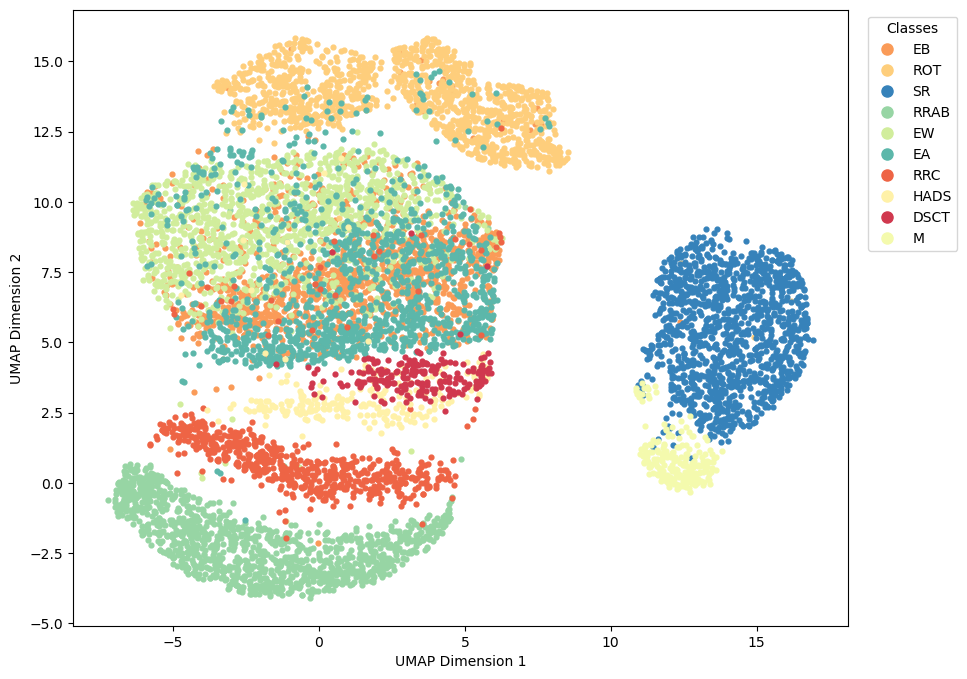

In [823]:
plot_one_embs(train_umap, train_labels)

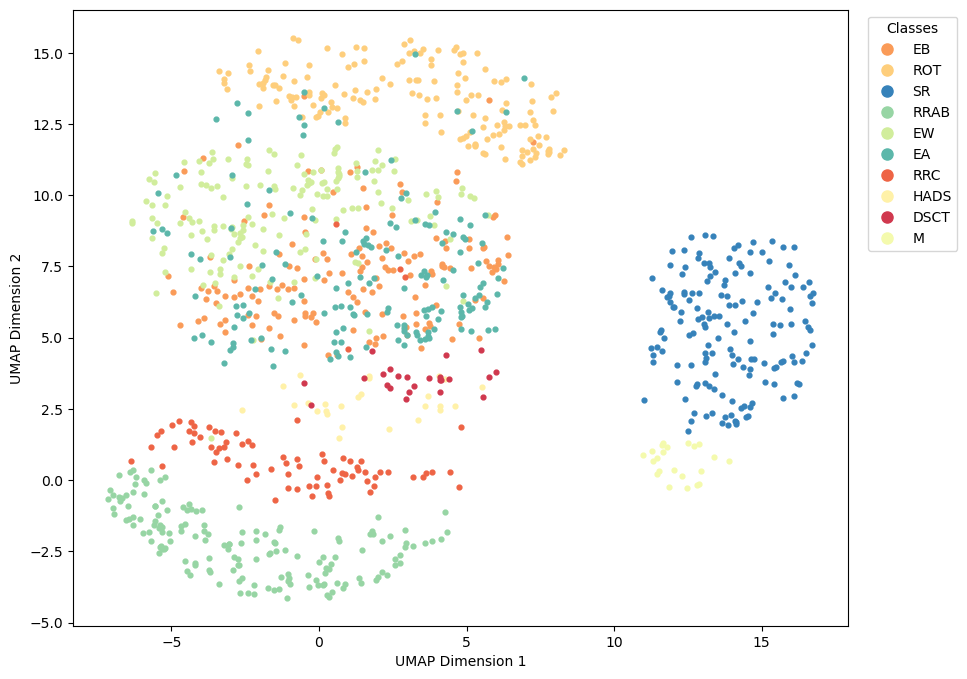

In [822]:
plot_one_embs(test_umap, test_labels)

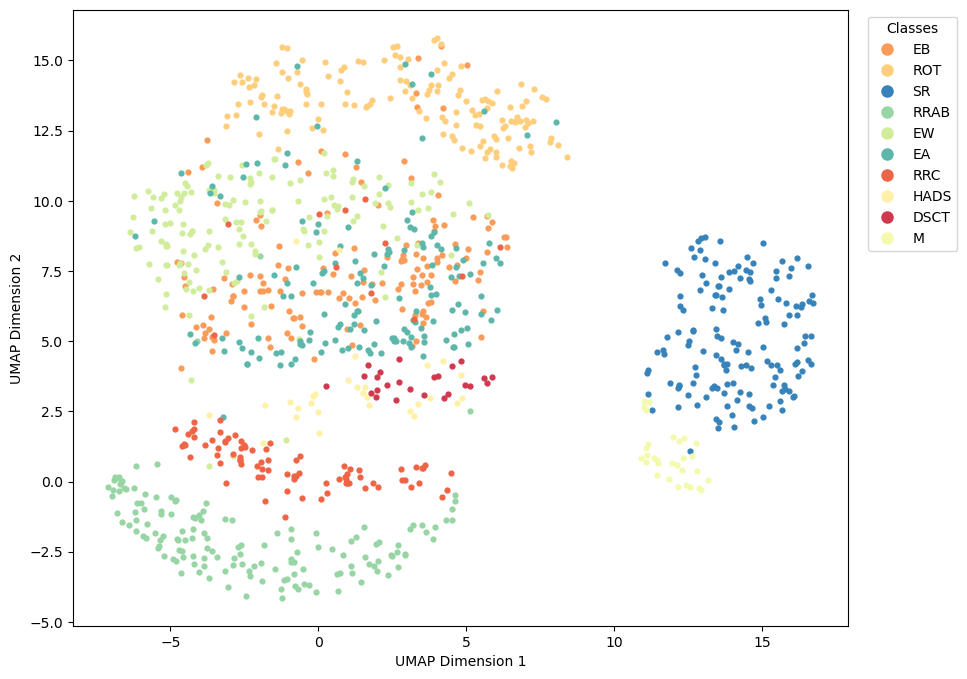

In [821]:
plot_one_embs(val_umap, val_labels)

In [308]:
outliers_mask = torch.zeros(train_labels.shape, dtype=torch.bool)

for i in range(10):
    ind = train_labels == i
    iso_forest = IsolationForest(contamination=0.03, random_state=42)  
    scores = iso_forest.fit_predict(train_umap[ind])
    scores = np.where(scores == -1, 1, 0)
    outliers_mask[ind] = torch.tensor(scores, dtype=torch.bool)

In [314]:
outliers_mask = torch.zeros(train_labels.shape, dtype=torch.bool)

for i in range(10):
    ind = train_labels == i
    lof = LocalOutlierFactor(n_neighbors=int(sum(ind).item() * 0.4))
    scores = lof.fit_predict(train_umap[ind])
    scores = np.where(scores == -1, 1, 0)
    outliers_mask[ind] = torch.tensor(scores, dtype=torch.bool)

In [557]:
outliers_mask = torch.zeros(train_labels.shape, dtype=torch.bool)
epselons = [2.0, 4.0, 4.0, 4.5, 3.0, 2.0, 3.6, 4.0, 4.0, 2.4]

for i in range(10):
    ind = train_labels == i
    dbscan = DBSCAN(eps=epselons[i], min_samples=int(sum(ind).item() * 0.5))
    scores = dbscan.fit_predict(train_umap[ind])
    scores = np.where(scores == -1, 1, 0)
    outliers_mask[ind] = torch.tensor(scores, dtype=torch.bool)

In [608]:
epselons = [2.0, 4.0, 4.0, 4.0, 3.0, 2.0, 3.6, 4.0, 4.0, 2.4]
out_mask_train = torch.zeros(train_labels.shape, dtype=torch.bool)
out_mask_test = torch.zeros(test_labels.shape, dtype=torch.bool)

for i in range(10):
    ind = train_labels == i
    dbscan = DBSCAN(eps=epselons[i], min_samples=int(sum(ind).item() * 0.5))
    scores_train = dbscan.fit_predict(train_umap[ind])
    out_mask_train[ind] = torch.tensor(np.where(scores_train == -1, 1, 0), dtype=torch.bool)

for i in range(10):
    ind = test_labels == i
    dbscan = DBSCAN(eps=epselons[i], min_samples=int(sum(ind).item() * 0.5))
    scores_test = dbscan.fit_predict(test_umap[ind])
    out_mask_test[ind] = torch.tensor(np.where(scores_test == -1, 1, 0), dtype=torch.bool)

In [824]:
epselons = [2.0, 4.0, 4.0, 4.0, 3.0, 2.0, 3.6, 4.0, 4.0, 2.4]
out_mask_val = torch.zeros(val_labels.shape, dtype=torch.bool)

for i in range(10):
    ind = val_labels == i
    dbscan = DBSCAN(eps=epselons[i], min_samples=int(sum(ind).item() * 0.5))
    scores_val = dbscan.fit_predict(val_umap[ind])
    out_mask_val[ind] = torch.tensor(np.where(scores_val == -1, 1, 0), dtype=torch.bool)

In [825]:
out_mask_train.sum(), out_mask_test.sum(), out_mask_val.sum()

(tensor(204), tensor(43), tensor(72))

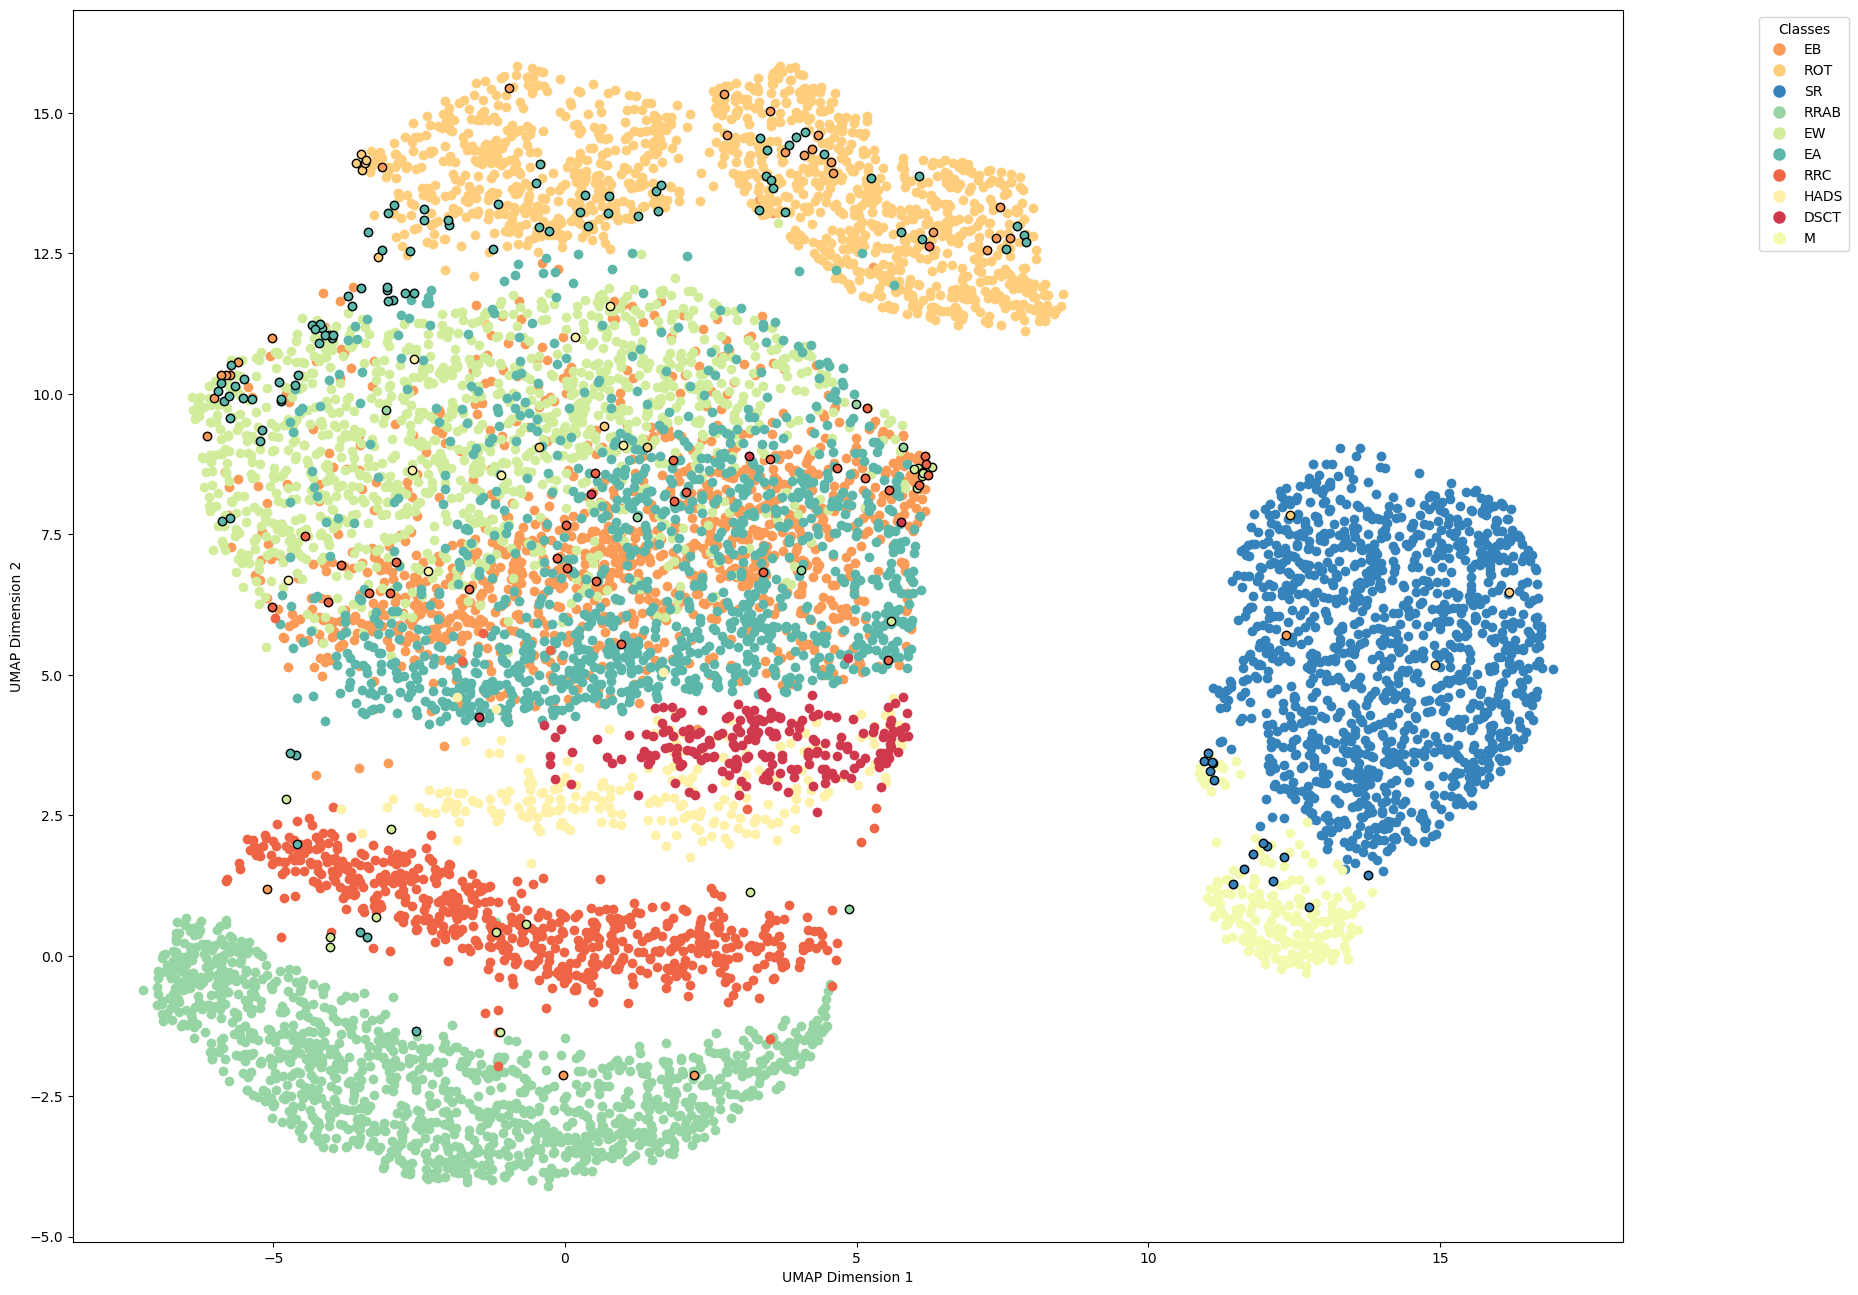

In [617]:
plot_one_embs_mask(train_umap, train_labels, out_mask_train)

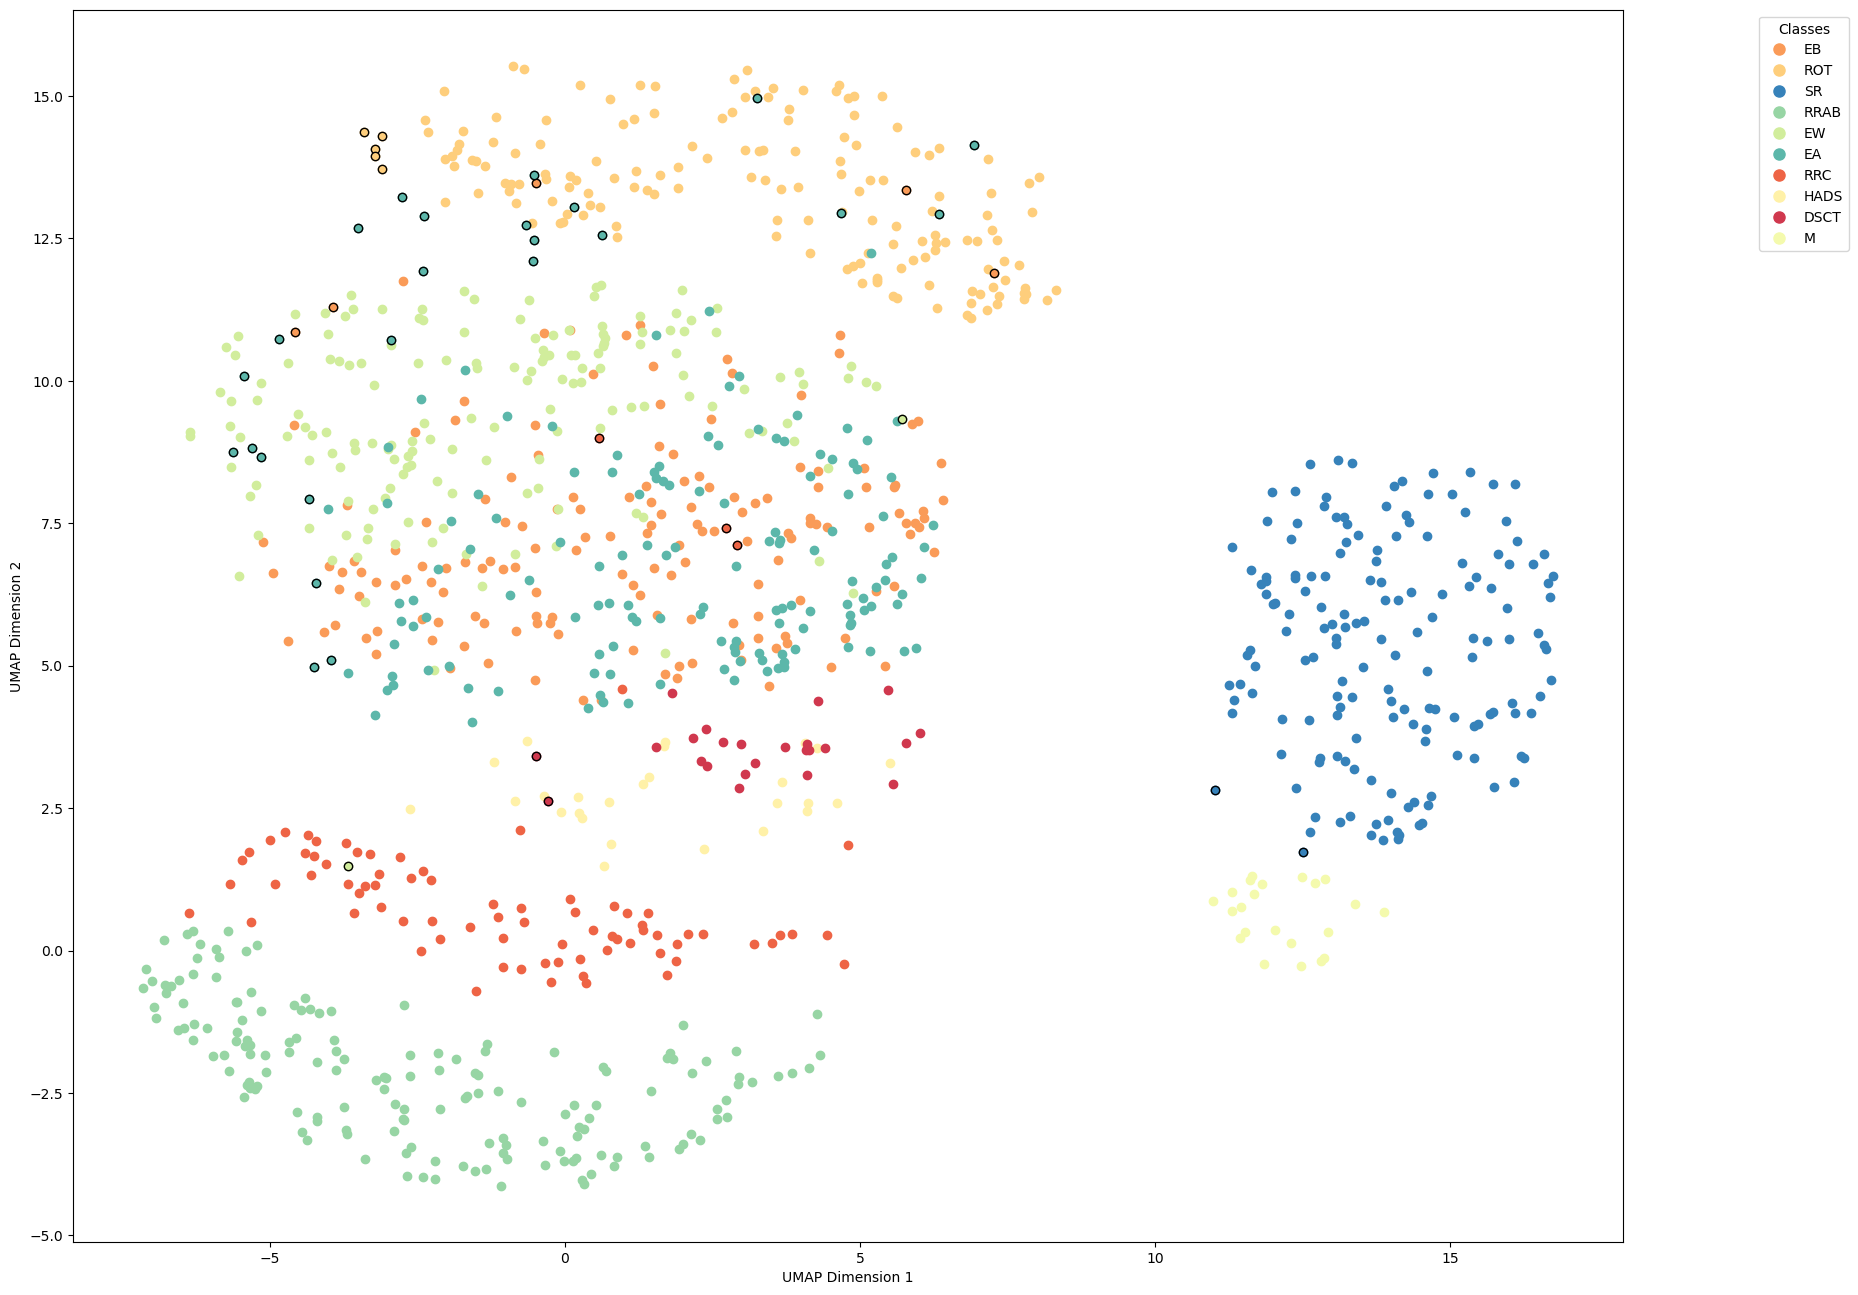

In [618]:
plot_one_embs_mask(test_umap, test_labels, out_mask_test)

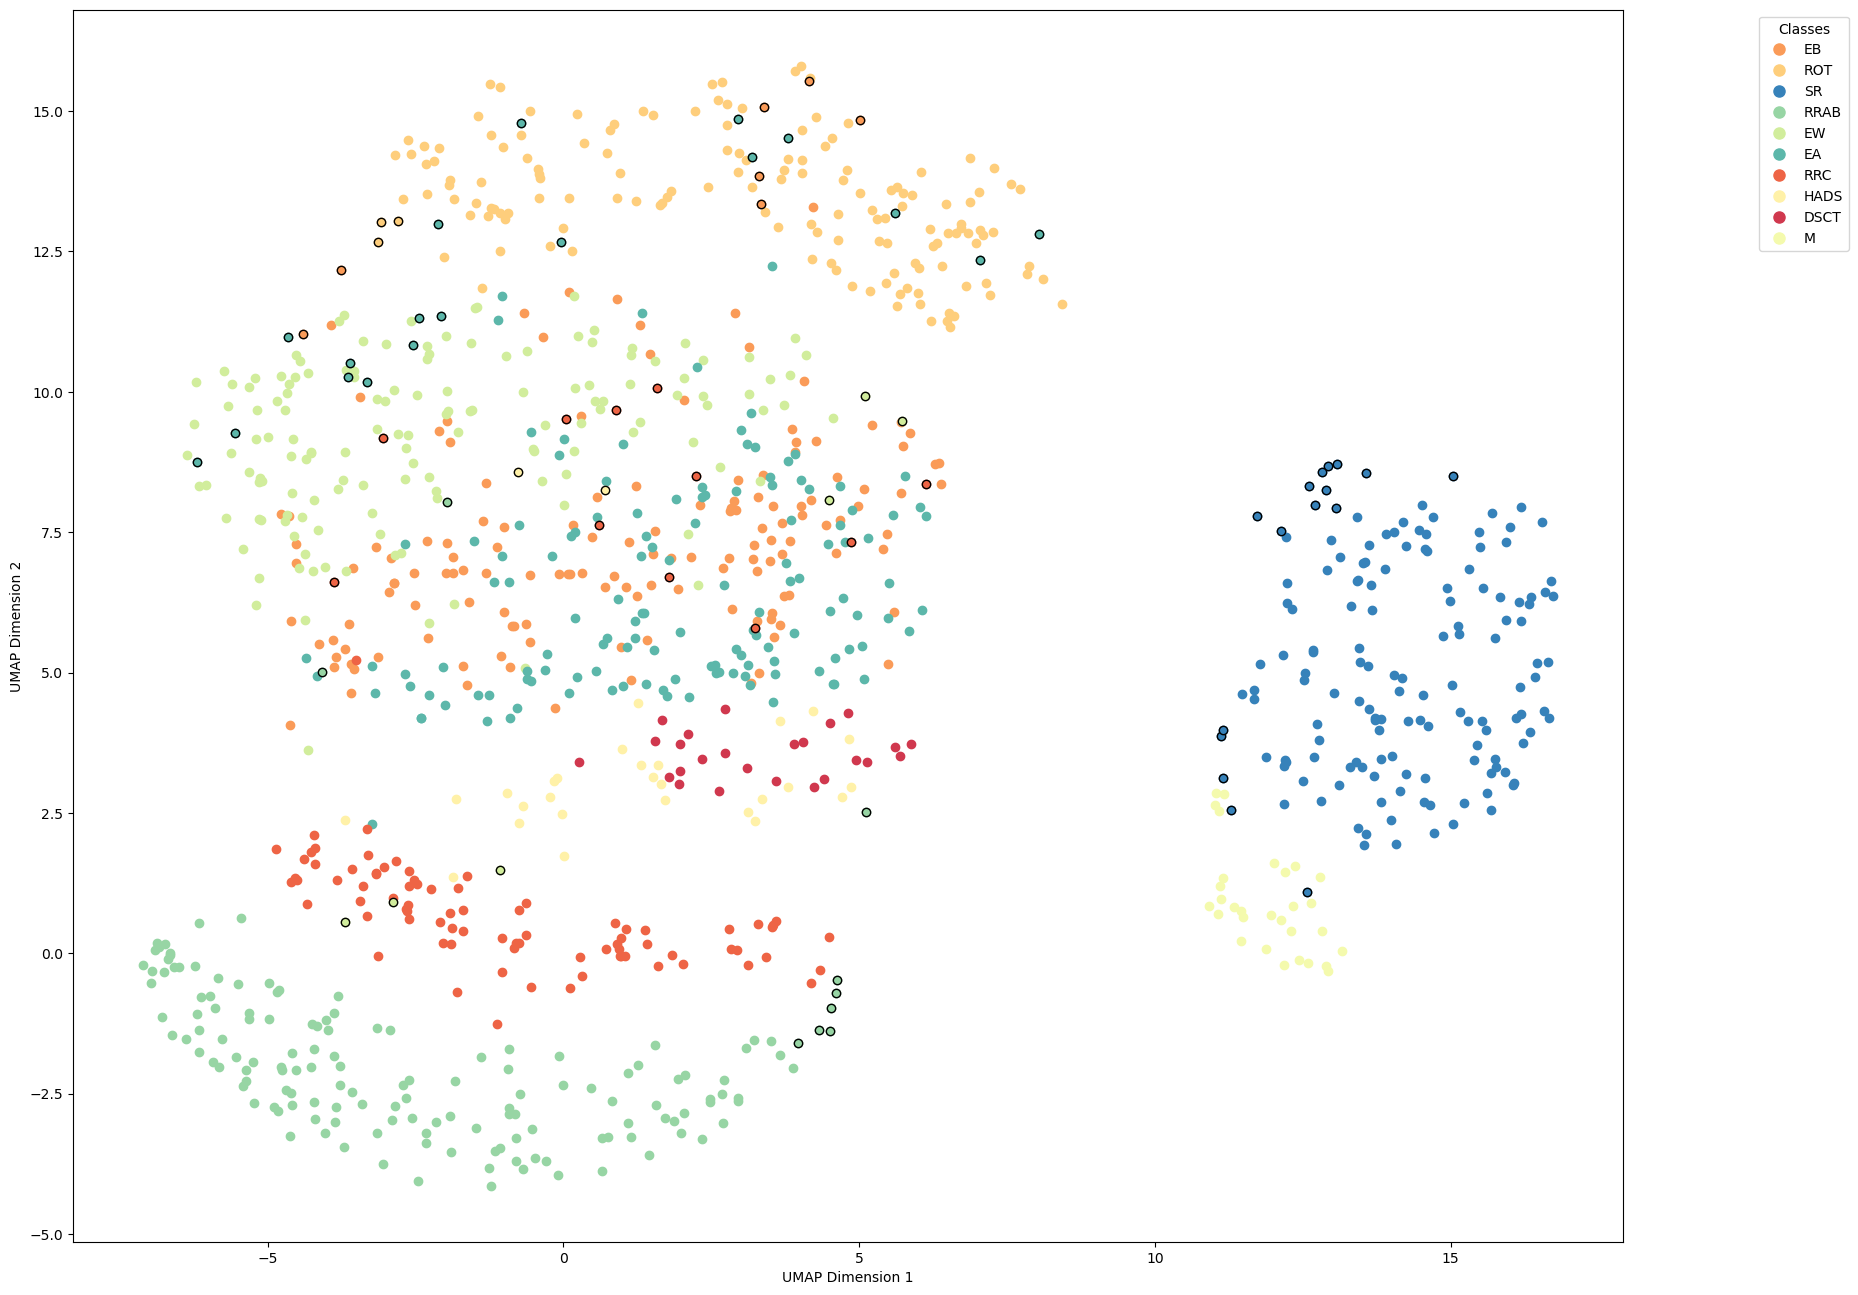

In [826]:
plot_one_embs_mask(val_umap, val_labels, out_mask_val)

In [655]:
train_period = np.array(np.log10(train_dataset.df['org_period']))
test_period = np.array(np.log10(test_dataset.df['org_period']))

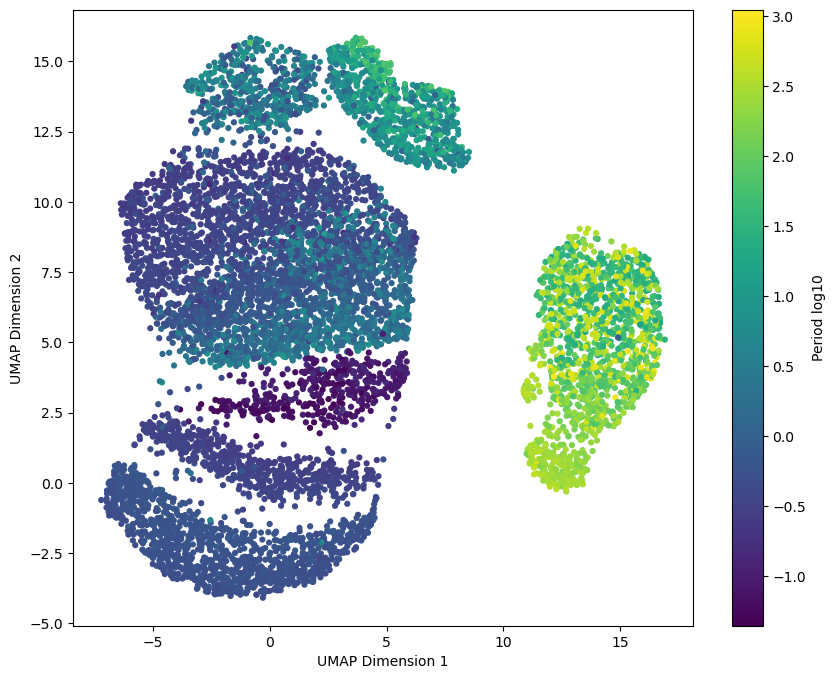

In [656]:
plot_one_embs_period(train_umap, train_period)

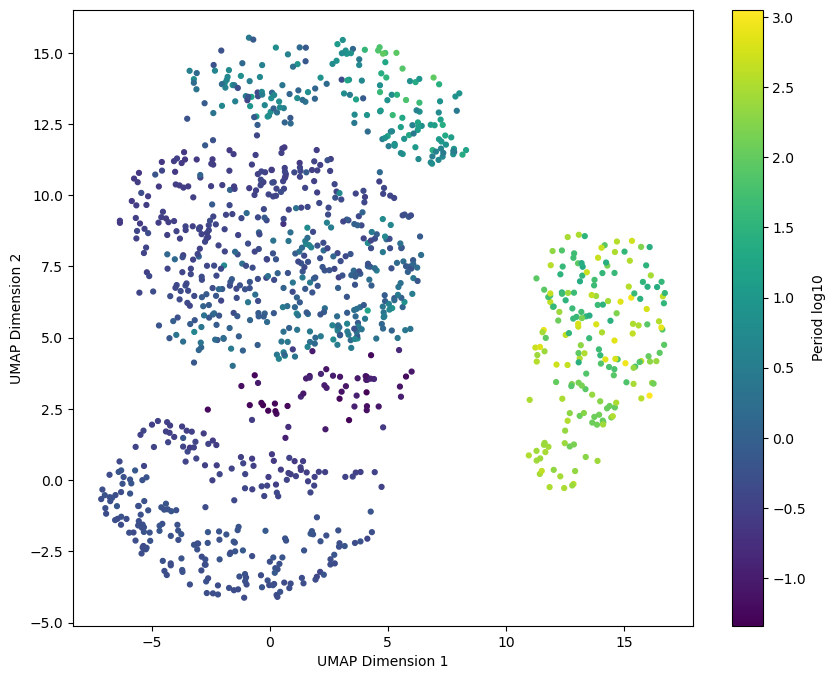

In [657]:
plot_one_embs_period(test_umap, test_period)

In [662]:
out_mask_test.sum()

tensor(43)

In [665]:
test_idx = torch.arange(len(test_dataset))[out_mask_test]
train_idx = torch.arange(len(train_dataset))[out_mask_train]

In [827]:
val_idx = torch.arange(len(val_dataset))[out_mask_val]

In [829]:
len(train_idx), len(val_idx), len(test_idx)

(204, 72, 43)

In [678]:
i = test_idx[0].item()
el = test_dataset.df.iloc[i]
label = target2id[el['target']]
period = el['org_period']

photometry = test_dataset.get_vlc(el['name'])
photometry = np.vstack(((photometry[:, 0] % period) / period, photometry[:, 1], photometry[:, 2])).T    # fold
spectra = test_dataset.readLRSFits(os.path.join(test_dataset.lamost_spec_dir, el['spec_filename']))

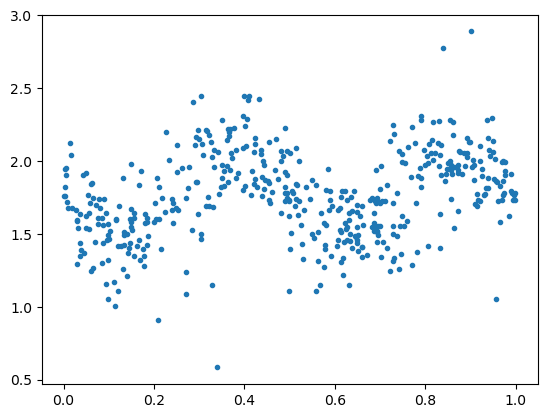

In [679]:
plt.plot(photometry[:, 0], photometry[:, 1], '.')

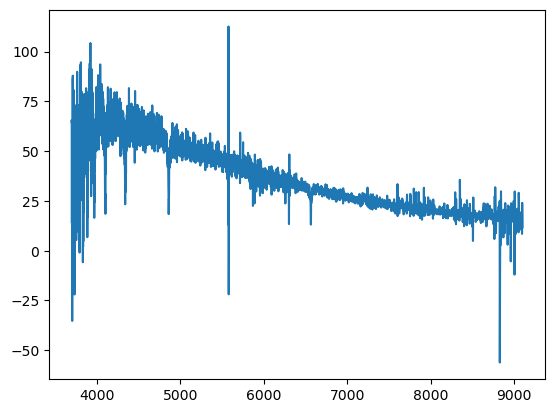

In [681]:
plt.plot(spectra[:, 0], spectra[:, 1])

In [21]:
def plot_obj(dataset, idx):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    
    photometry = dataset.get_vlc(el['name'])
    photometry = np.vstack(((photometry[:, 0] % period) / period, photometry[:, 1], photometry[:, 2])).T    # fold
    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(photometry[:, 0], photometry[:, 1], '.', label='Photometry')
    plt.subplot(1, 2, 2)
    plt.plot(spectra[:, 0], spectra[:, 1], label='Spectra')
    plt.suptitle(f'period = {period}    label = {id2target[label]}')
    plt.tight_layout()
    plt.show()

In [22]:
def plot_obj_umap(dataset, idx, embeddings, targets):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    l, b = id2lb[el['id']]

    photometry = dataset.get_vlc(el['name'])
    photometry = np.vstack(((photometry[:, 0] % period) / period, photometry[:, 1], photometry[:, 2])).T    # fold
    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))

    obj_embedding = embeddings[idx]
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    axs[0].plot(photometry[:, 0], photometry[:, 1], '.', label='Photometry')
    axs[1].plot(spectra[:, 0], spectra[:, 1], label='Spectra')
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        axs[2].scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                       color=palette[class_id], label=class_name, alpha=1.0, s=marker_size)

    axs[2].scatter(obj_embedding[0], obj_embedding[1], color=palette[targets[idx]], edgecolors='black', alpha=1.0, s=5 * marker_size)
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    axs[2].legend(handles=handles_colors, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    
    
    plt.suptitle(f'period = {period}    label = {id2target[label]}     idx {idx}    L = {l}    B = {b}    id {el["id"]}')
    plt.tight_layout()
    plt.show()

In [782]:
test_dataset.df.iloc[120]['id']

'EDR3 1284904239000978944'

In [778]:
df = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv')

In [781]:
df[df['id'] == 'EDR3 1284904239000978944']

mean_vmag  amplitude    period  phot_g_mean_mag  e_phot_g_mean_mag  \
243      15.73       0.45  0.383351        15.319804           0.004551   

     lksl_statistic  rfr_score  phot_bp_mean_mag  e_phot_bp_mean_mag  \
243            0.59       0.68         15.888126            0.014277   

     phot_rp_mean_mag  ...  w1_w2  w3_w4      pm   ruwe  \
243         14.558028  ...  0.078  3.115  37.612  1.016   

                           id  target                         name  \
243  EDR3 1284904239000978944      EB  ASASSN-VJ142305.61+301240.1   

                                      spec_filename         l         b  
243  spec-58963-HD142214N292211B02_sp15-122.fits.gz  47.08967  69.69577  

[1 rows x 42 columns]

In [801]:
train_df_org = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv')
test_df_org = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv')

In [793]:
train_dataset.df.iloc[1235]['id']

'EDR3 3372147259826502272'

In [796]:
train_df_org[train_df_org['id'] == train_dataset.df.iloc[6265]['id']]

mean_vmag  amplitude    period  phot_g_mean_mag  e_phot_g_mean_mag  \
12774      14.08        0.5  4.086261         13.55405           0.007454   

       lksl_statistic  rfr_score  phot_bp_mean_mag  e_phot_bp_mean_mag  \
12774            0.09       0.96         14.320715            0.024495   

       phot_rp_mean_mag  ...  w1_w2  w3_w4   pm   ruwe  \
12774          12.69359  ...  0.009  1.625  4.9  1.079   

                           id  target                         name  \
12774  EDR3 45787237593398144      EA  ASASSN-VJ041806.15+165653.6   

                                         spec_filename          l         b  
12774  spec-58840-KII041801N181524V01_sp05-016.fits.gz  177.69792 -23.27293  

[1 rows x 42 columns]

In [802]:
test_dataset.df.iloc[120]['id']

'EDR3 1284904239000978944'

In [803]:
config['lamost_spec_dir']

'Spectra/v2'

In [804]:
spectra_df_org = pd.read_csv('/home/mariia/AstroML/data/asassn/Spectra/lamost_spec.csv')

In [806]:
spectra_df_org[spectra_df_org['edr3_source_id'] == test_dataset.df.iloc[120]['id']]

Unnamed: 0  inputobjs_input_id  inputobjs_input_ra  inputobjs_input_dec  \
6972        6972               54402           215.77337             30.21114   
6973        6973               54402           215.77337             30.21114   

      inputobjs_dist  combined_obsid combined_obsdate  combined_lmjd  \
6972        0.518697        42215122       2012-02-17          55975   
6973        0.477114       820515122       2020-04-23          58963   

      combined_mjd     combined_planid  ...  combined_dec  combined_feh  \
6972         55974            B5597506  ...     30.211021           NaN   
6973         58962  HD142214N292211B02  ...     30.211067        -0.566   

     combined_logg combined_rv  combined_teff    raj2000   dej2000  \
6972           NaN         NaN            NaN  215.77337  30.21114   
6973          4.33      -45.25        4640.16  215.77337  30.21114   

                edr3_source_id  index  \
6972  EDR3 1284904239000978944  54402   
6973  EDR3 1284904239000978944  54402   

                                       spec_filename  
6972            spec-55975-B5597506_sp15-122.fits.gz  
6973  spec-58963-HD142214N292211B02_sp15-122.fits.gz  

[2 rows x 26 columns]

In [814]:
spectra1 = test_dataset.readLRSFits(os.path.join(test_dataset.lamost_spec_dir, 'spec-q-B5597506_sp15-122.fits.gz'))
spectra2 = test_dataset.readLRSFits(os.path.join(test_dataset.lamost_spec_dir, 'spec-58963-HD142214N292211B02_sp15-122.fits.gz'))

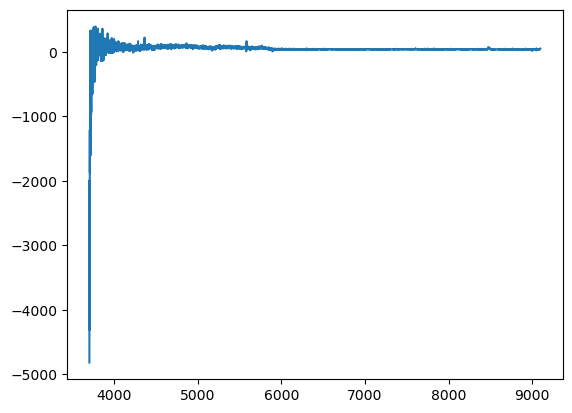

In [815]:
plt.plot(spectra1[:, 0], spectra1[:, 1])

(0.0, 150.0)

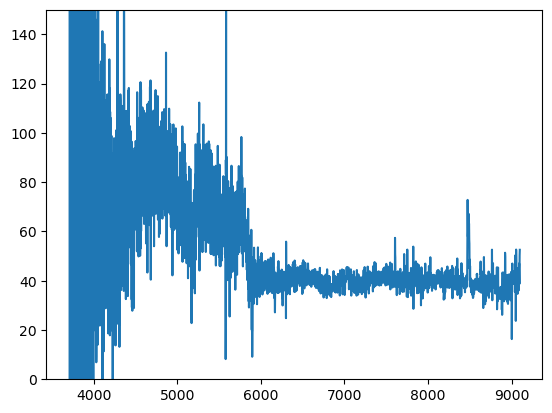

In [816]:
plt.plot(spectra1[:, 0], spectra1[:, 1])
plt.ylim(0, 150)

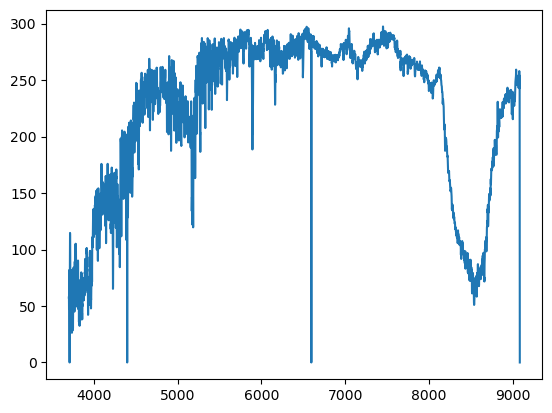

In [809]:
plt.plot(spectra2[:, 0], spectra2[:, 1])

In [831]:
joblib.dump(train_idx, 'train_idx.pkl')
joblib.dump(val_idx, 'val_idx.pkl')
joblib.dump(test_idx, 'test_idx.pkl')

['test_idx.pkl']

In [23]:
test_idx = joblib.load('test_idx.pkl')
val_idx = joblib.load('val_idx.pkl')
train_idx = joblib.load('train_idx.pkl')

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO

In [32]:
def plot_photometry(dataset, idx):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    
    photometry = dataset.get_vlc(el['name'])
    photometry = np.vstack(((photometry[:, 0] % period) / period, photometry[:, 1], photometry[:, 2])).T    # fold
    
    plt.figure(figsize=(6, 5))
    plt.plot(photometry[:, 0], photometry[:, 1], '.', label='Photometry')
    plt.suptitle(f'period = {period}    label = {id2target[label]}')
    plt.tight_layout()
    plt.show()

In [51]:
def plot_spectra(dataset, idx, window_length=51, polyorder=3):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    
    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))
    smoothed_spectra = savgol_filter(spectra[:, 1], window_length=window_length, polyorder=polyorder)

    plt.figure(figsize=(6, 5))
    plt.plot(spectra[:, 0], spectra[:, 1], color='gray', alpha=0.4, label='Original Spectra')
    plt.plot(spectra[:, 0], smoothed_spectra, color='blue', linewidth=1.5, label='Smoothed Spectra')
    # plt.title(f'period = {period}    label = {id2target[label]}')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

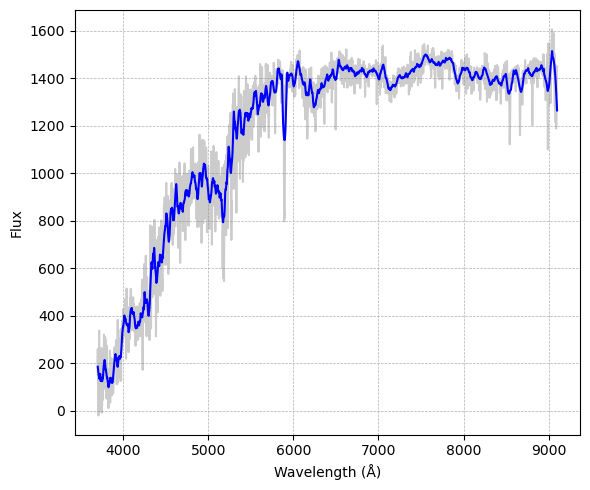

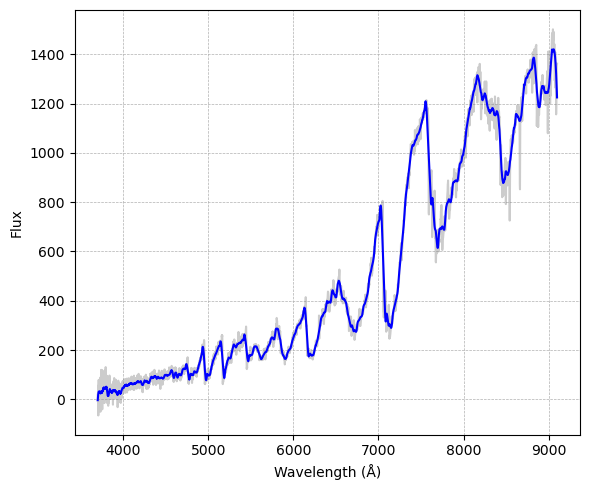

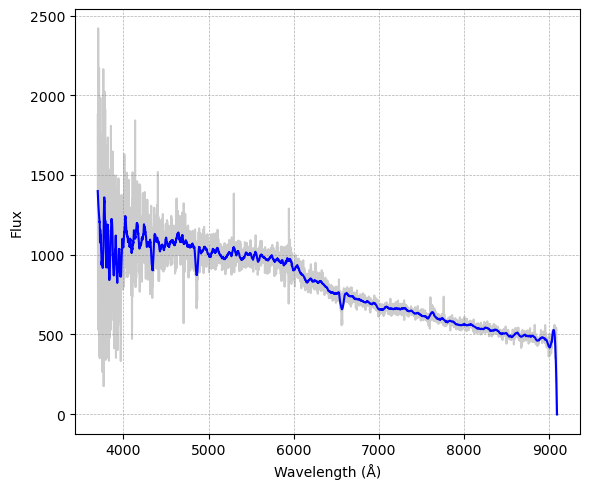

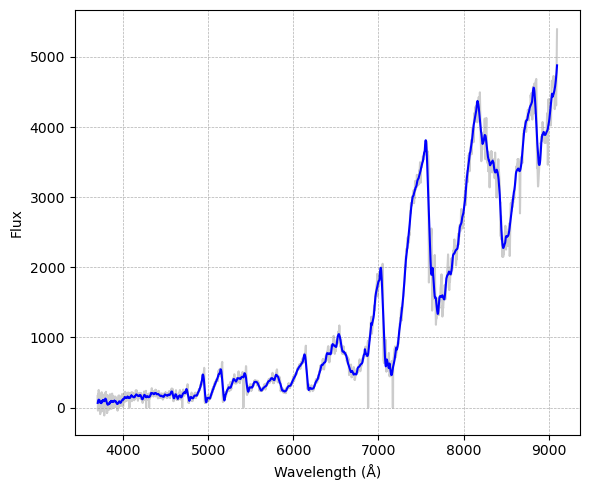

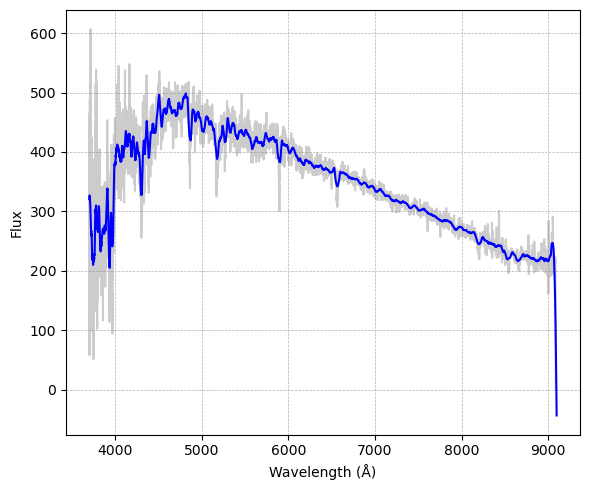

In [53]:
for i in range(5):
    plot_spectra(test_dataset, test_idx[i].item())

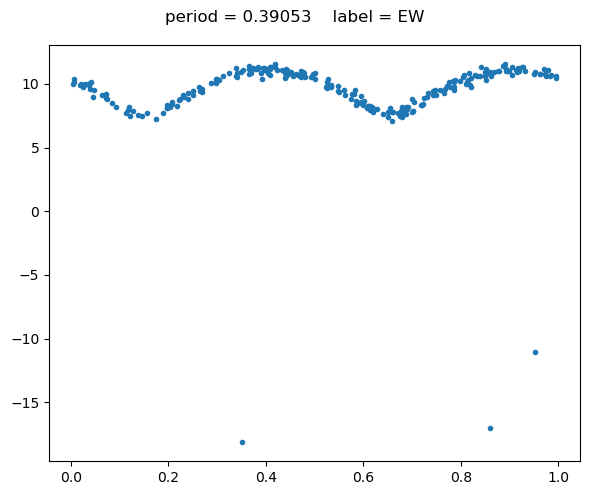

In [35]:
plot_photometry(test_dataset, test_idx[2].item())

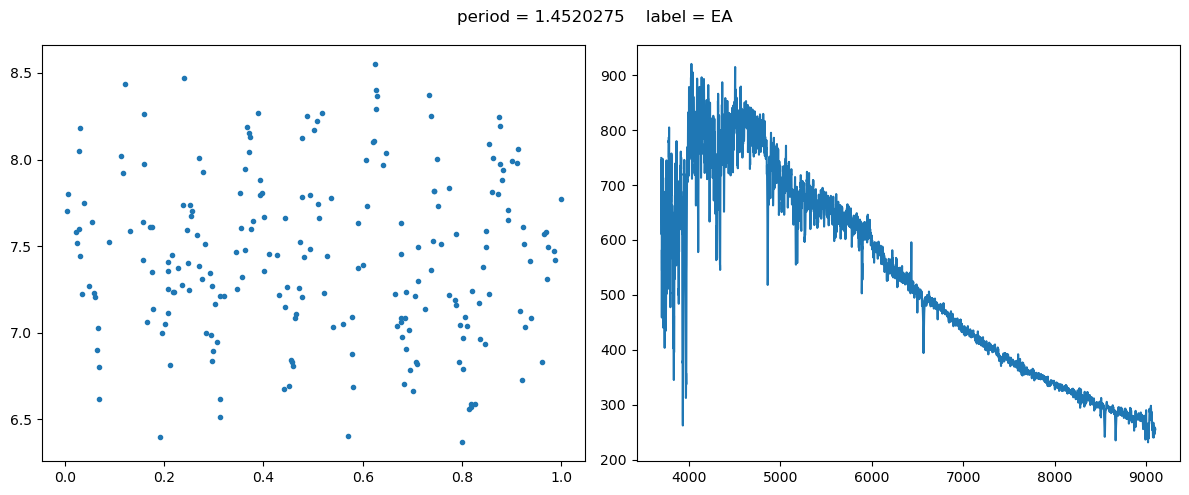

In [56]:
plot_obj(test_dataset, 120)

In [ ]:
for el in test_idx:
    plot_obj_umap(test_dataset, el.item(), test_umap, test_labels)

In [ ]:
for el in train_idx:
    plot_obj_umap(train_dataset, el.item(), train_umap, train_labels)

In [ ]:
for el in val_idx:
    plot_obj_umap(val_dataset, el.item(), val_umap, val_labels)

In [35]:
all_p_emb, all_s_emb, all_m_emb = [], [], []
all_logits_ps, all_logits_sm, all_logits_mp = [], [], []
all_labels = []

for photometry, photometry_mask, spectra, metadata, labels in tqdm(test_dataloader):
    photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
    spectra, metadata = spectra.to(device), metadata.to(device)

    with torch.no_grad():
        p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)

        all_p_emb.append(p_emb.cpu())
        all_s_emb.append(s_emb.cpu())
        all_m_emb.append(m_emb.cpu())
        all_labels.append(labels)

        logit_scale_ps = torch.clamp(model.logit_scale_ps.exp(), min=1, max=100)
        logit_scale_sm = torch.clamp(model.logit_scale_sm.exp(), min=1, max=100)
        logit_scale_mp = torch.clamp(model.logit_scale_mp.exp(), min=1, max=100)
    
        logits_ps = logit_scale_ps * p_emb @ s_emb.T
        logits_sm = logit_scale_sm * s_emb @ m_emb.T
        logits_mp = logit_scale_mp * m_emb @ p_emb.T

        all_logits_ps.append(logits_ps.cpu())
        all_logits_sm.append(logits_sm.cpu())
        all_logits_mp.append(logits_mp.cpu())

p_emb = torch.vstack(all_p_emb)
s_emb = torch.vstack(all_s_emb)
m_emb = torch.vstack(all_m_emb)
labels = torch.hstack(all_labels)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.63s/it]


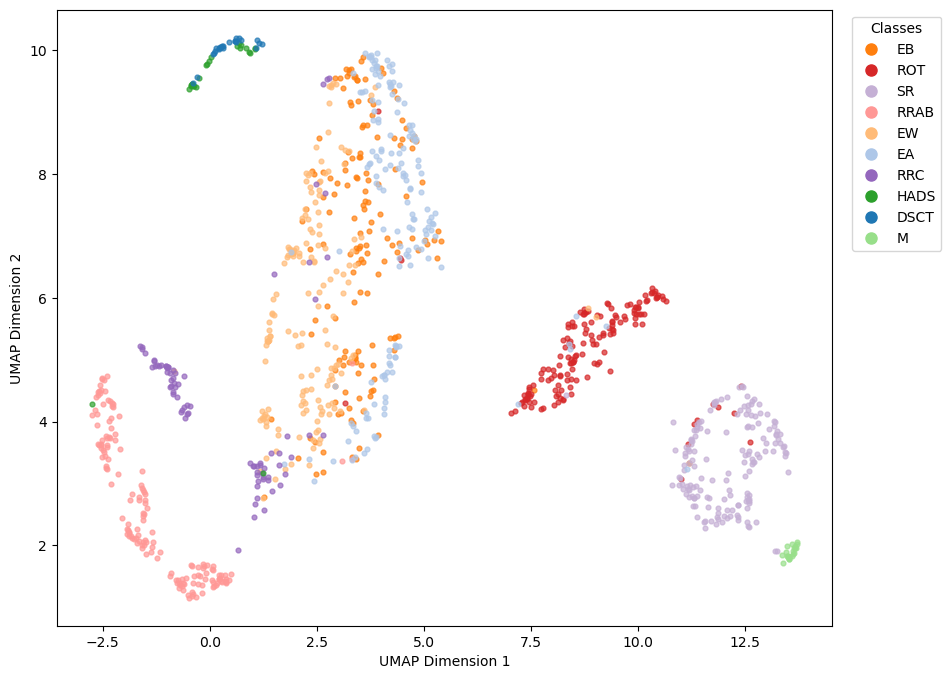

In [37]:
umap_model = umap.UMAP(n_neighbors=22, n_components=2, metric='cosine', n_jobs=1, random_state=42)
p_emb_umap = umap_model.fit_transform(p_emb)
plot_one_embs(p_emb_umap, labels)

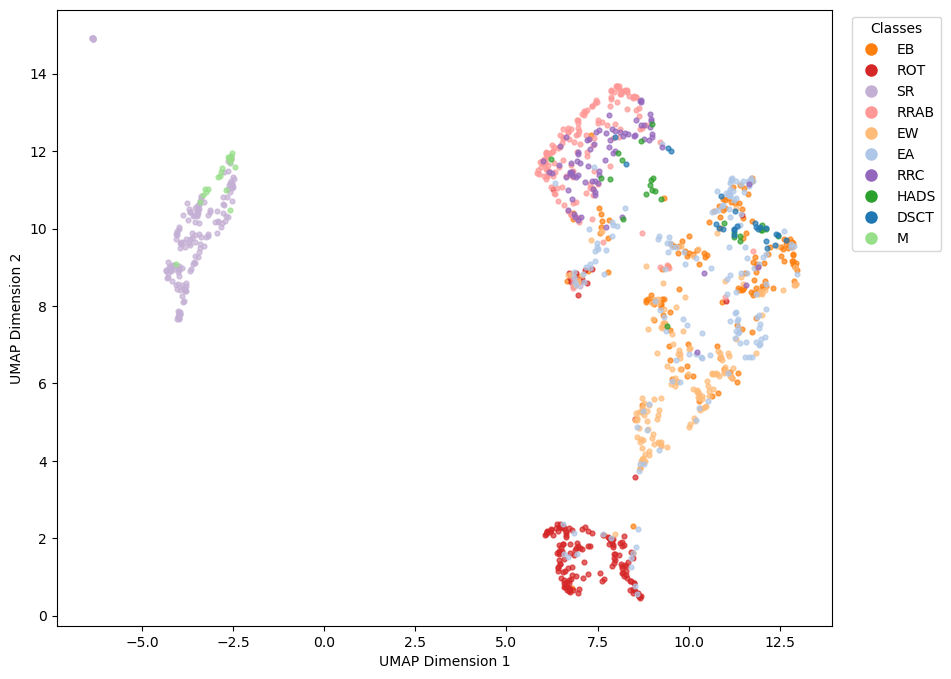

In [38]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=1, random_state=42)
s_emb_umap = umap_model.fit_transform(s_emb)
plot_one_embs(s_emb_umap, labels)

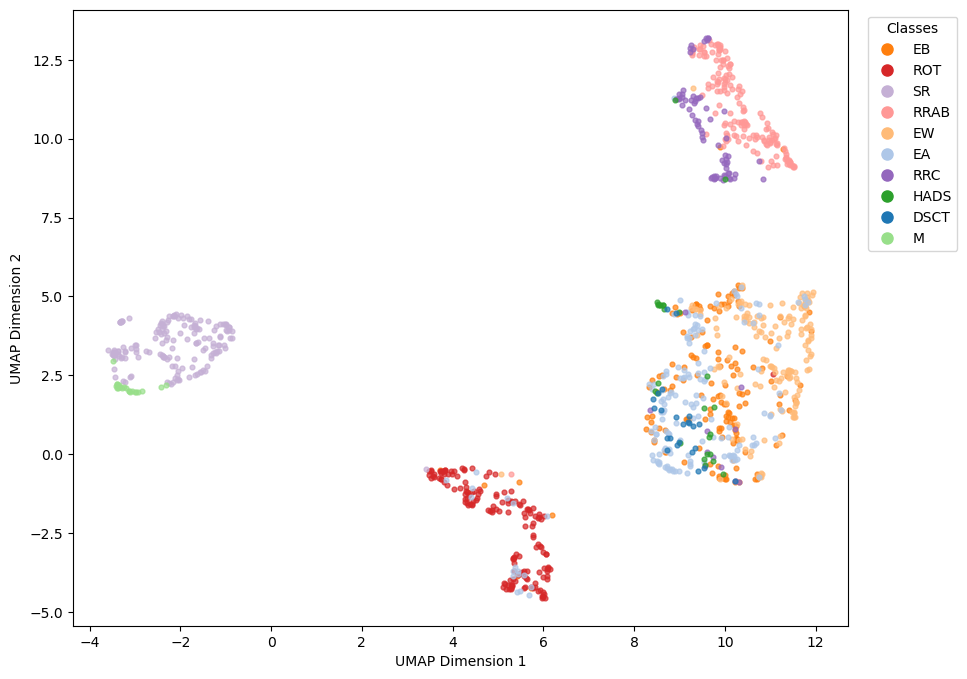

In [39]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=1, random_state=42)
m_emb_umap = umap_model.fit_transform(m_emb)
plot_one_embs(m_emb_umap, labels)

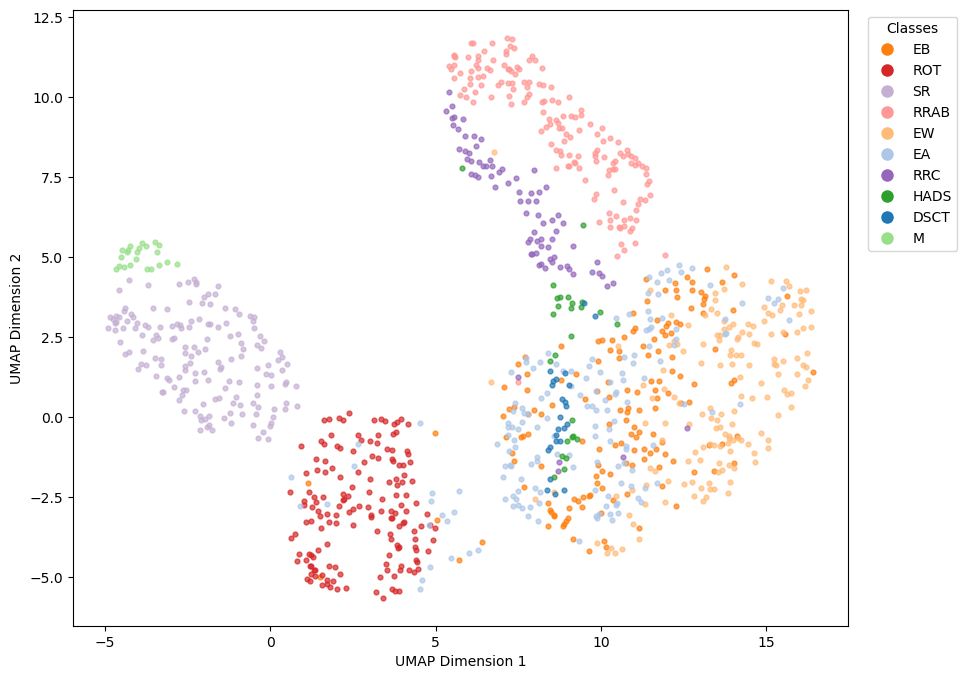

In [48]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.7, n_components=2, metric='cosine', n_jobs=1, random_state=42)
emb = (p_emb + s_emb + m_emb) / 3
emb_umap = umap_model.fit_transform(emb)
plot_one_embs(emb_umap, labels)

In [72]:
def plot_one_embs_centers(embeddings, targets, centers):
    plt.figure(figsize=(10, 8))
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        plt.scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=0.7, s=marker_size)
        plt.scatter(centers[class_id][0], centers[class_id][1], color=palette[class_id], 
                    marker='D', s=30, edgecolor='black', label=f"{class_name} center")
        
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    plt.legend(handles=handles_colors, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

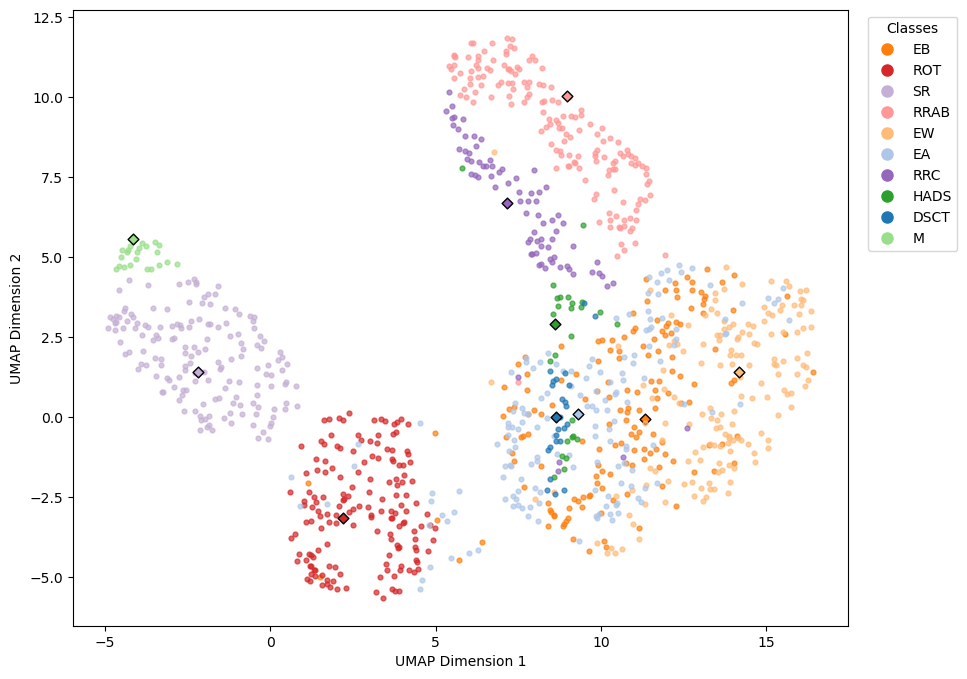

In [87]:
plot_one_embs_centers(emb_umap, labels, centers_umap)

In [88]:
centers = []

for i in range(10):
    ind = labels == i
    center = emb[ind].mean(axis=0)
    centers.append(center)

centers = torch.stack(centers)

In [86]:
centers_umap = umap_model.transform(centers)

In [89]:
centers.shape

torch.Size([10, 512])

In [90]:
(emb @ centers.T).shape

torch.Size([1111, 10])

In [84]:
emb[0].norm()

tensor(0.8446)

In [93]:
dist = cdist(emb, centers, metric='cosine')

In [98]:
dist.shape

(1111, 10)

In [95]:
dist[labels].shape

(1111, 10)

In [97]:
labels.shape

torch.Size([1111])

In [108]:
dist_l = dist[torch.arange(dist.shape[0]), labels]

(array([ 66., 200., 311., 255., 153.,  61.,  31.,  21.,   8.,   5.]),
 array([0.03515503, 0.1350999 , 0.23504476, 0.33498962, 0.43493448,
        0.53487934, 0.6348242 , 0.73476906, 0.83471392, 0.93465878,
        1.03460364]),
 <BarContainer object of 10 artists>)

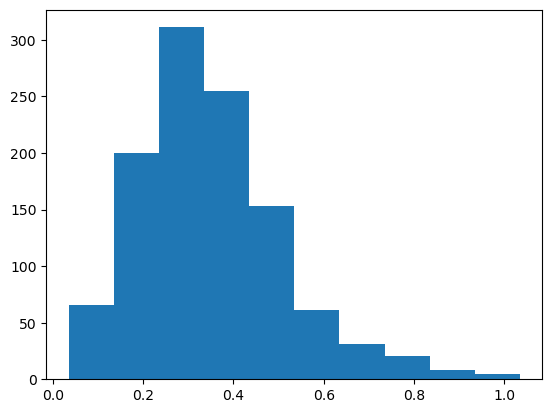

In [109]:
plt.hist(dist_l)

In [112]:
len(dist_l[dist_l > 0.8])

15

In [115]:
dist[dist_l > 0.8], labels[dist_l > 0.8]

(array([[1.08776239, 0.82109795, 0.86800268, 0.58868897, 0.9016669 ,
         0.87433704, 0.6676734 , 0.75004197, 0.68554675, 1.00677098],
        [1.24615683, 1.00628368, 0.98935157, 0.40912337, 1.08966196,
         0.98973041, 1.10409647, 0.64247559, 0.59673142, 1.05566637],
        [0.82774487, 0.82109923, 0.5917079 , 0.83508824, 0.90593411,
         1.13707557, 1.16051708, 0.97090854, 0.91685982, 1.0458675 ],
        [1.09646628, 0.88589815, 0.92322341, 0.87176105, 1.05801397,
         0.80623395, 0.82672204, 0.81686045, 0.86911133, 0.9255806 ],
        [0.9093653 , 0.94189265, 0.81067855, 0.82004199, 0.99093712,
         1.09685975, 1.26409932, 1.02687479, 0.92452074, 1.08252962],
        [0.64509181, 0.61068178, 0.42369129, 0.9850445 , 0.78292367,
         1.05630162, 1.0333638 , 1.02694385, 1.0037285 , 0.96480294],
        [0.91664279, 0.75102709, 0.88530453, 0.7228447 , 1.0560763 ,
         1.20110636, 0.90633152, 1.08664608, 1.01869541, 1.07192511],
        [0.56668124, 0.5961

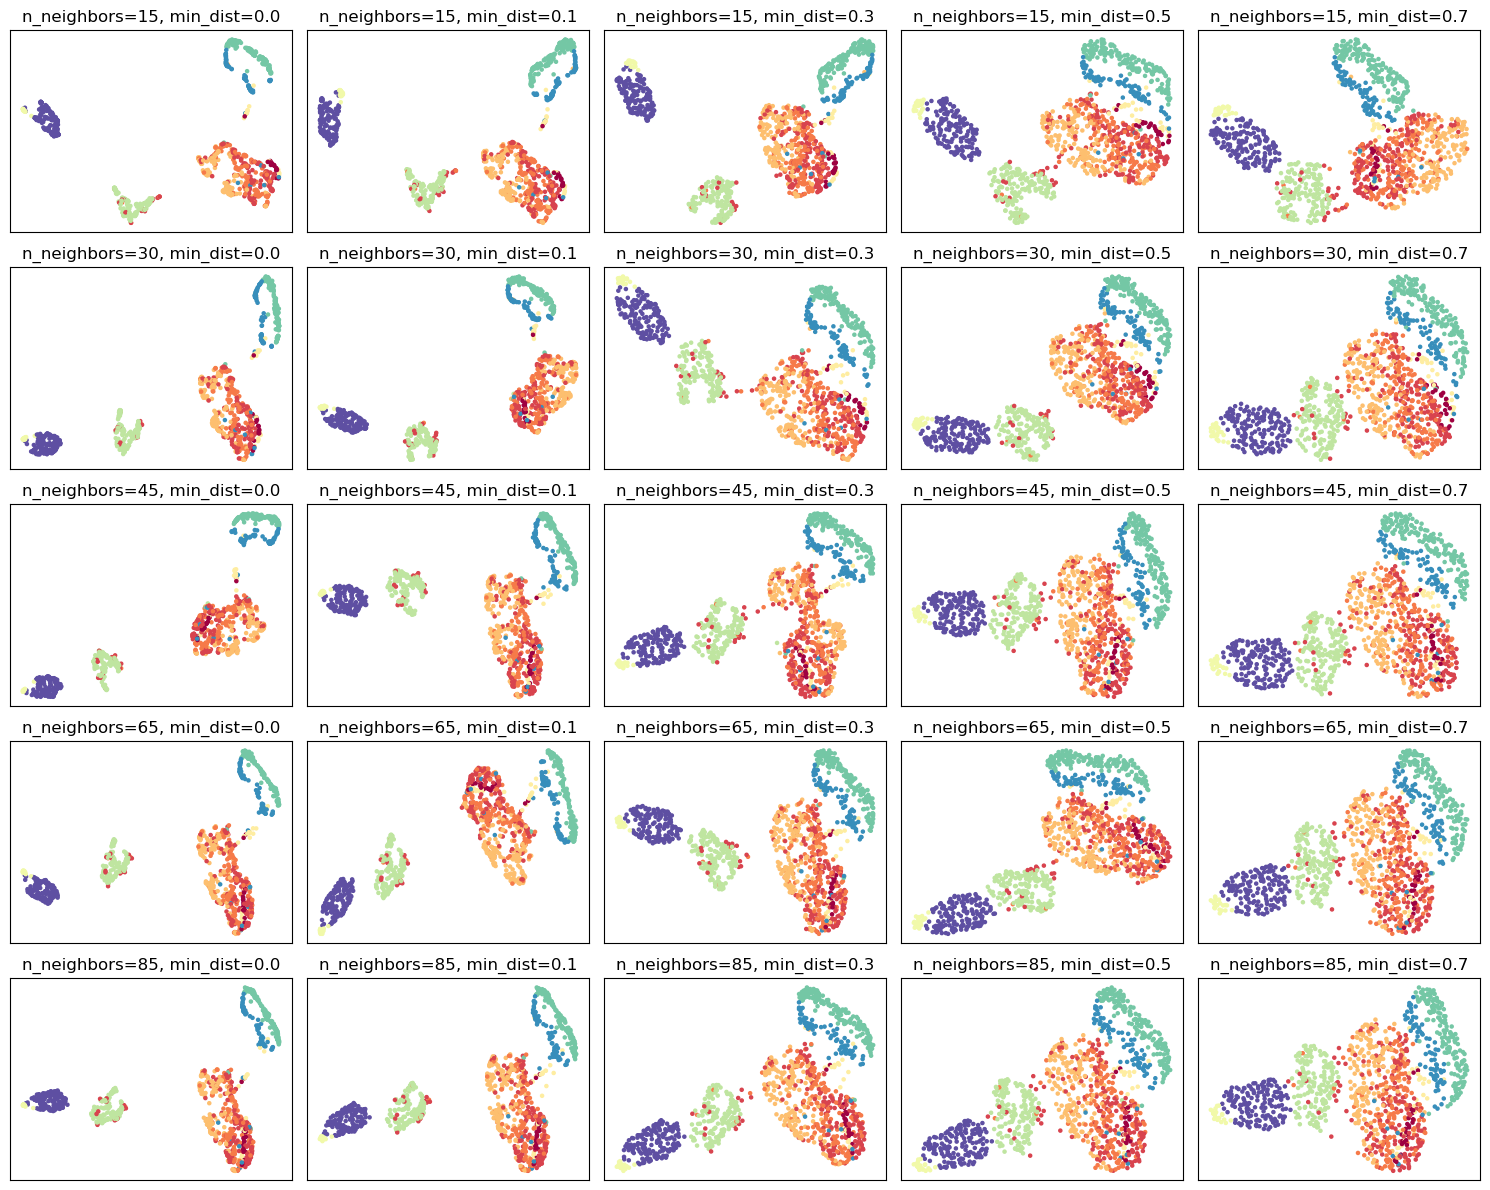

In [45]:
n_neighbors_list = [15, 30, 45, 65, 85]
min_dist_list = [0.0, 0.1, 0.3, 0.5, 0.7]

emb = (p_emb + s_emb + m_emb) / 3
fig, axs = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 12))

for i, n_neighbors in enumerate(n_neighbors_list):
    for j, min_dist in enumerate(min_dist_list):
        umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric='cosine', n_jobs=1, random_state=42)
        emb_umap = umap_model.fit_transform(emb)
        
        ax = axs[i, j]
        ax.scatter(emb_umap[:, 0], emb_umap[:, 1], c=labels, cmap='Spectral', s=5)
        ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

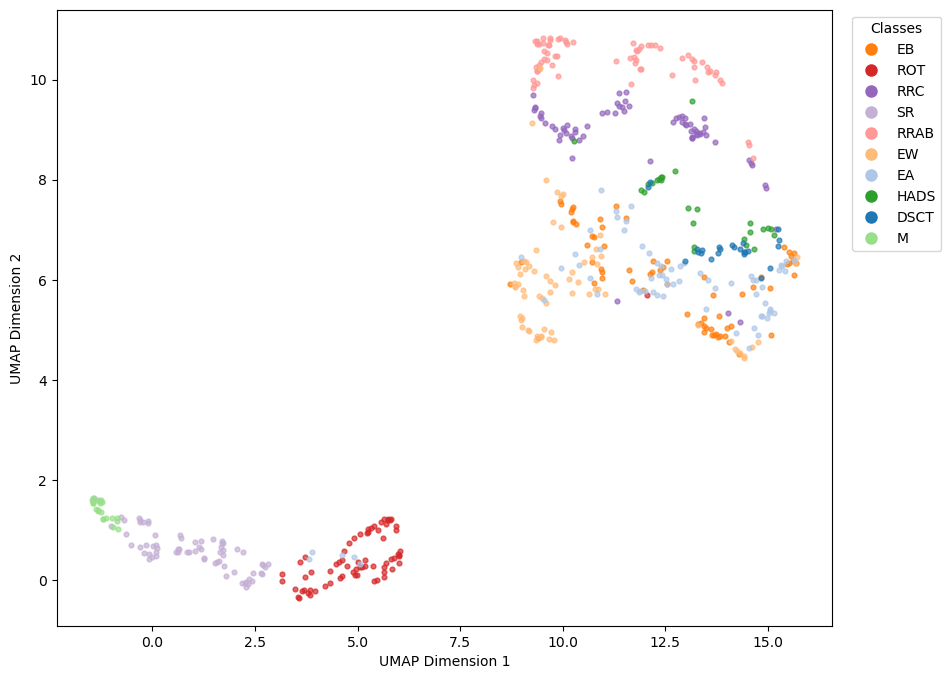

In [31]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=1, random_state=42)
emb = (p_emb + s_emb + m_emb) / 3
emb_umap = umap_model.fit_transform(emb)
plot_one_embs(emb_umap, labels)

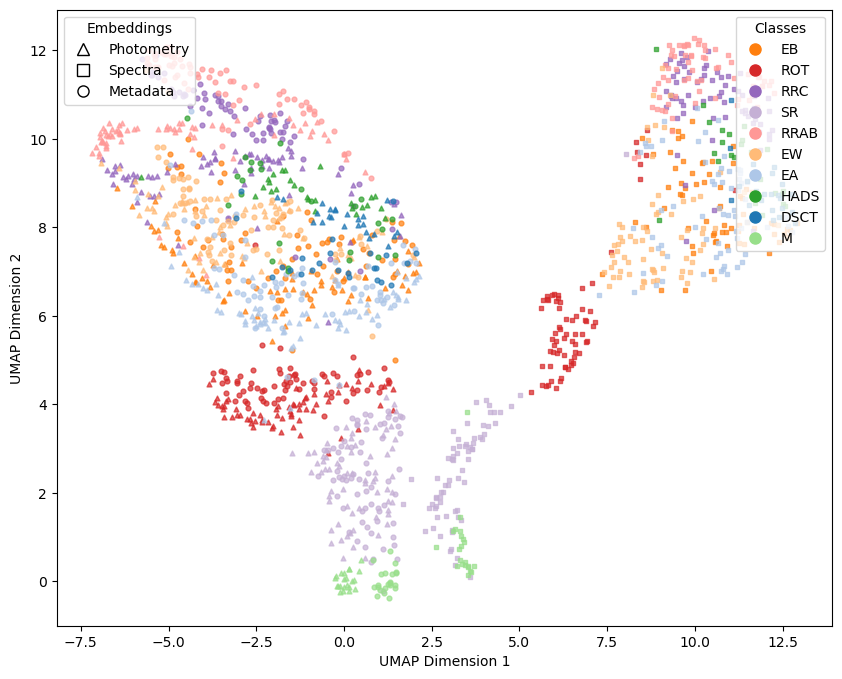

In [32]:
umap_model = umap.UMAP(n_neighbors=45, min_dist=0.5, n_components=2, metric='cosine', n_jobs=1, random_state=42)
combined_emb = torch.vstack([p_emb, s_emb, m_emb])
combined_emb_umap = umap_model.fit_transform(combined_emb)

p_umap = combined_emb_umap[:len(p_emb)]
s_umap = combined_emb_umap[len(p_emb):len(p_emb) + len(s_emb)]
m_umap = combined_emb_umap[len(p_emb) + len(s_emb):]

plot_three_embs(p_umap, s_umap, m_umap, labels)

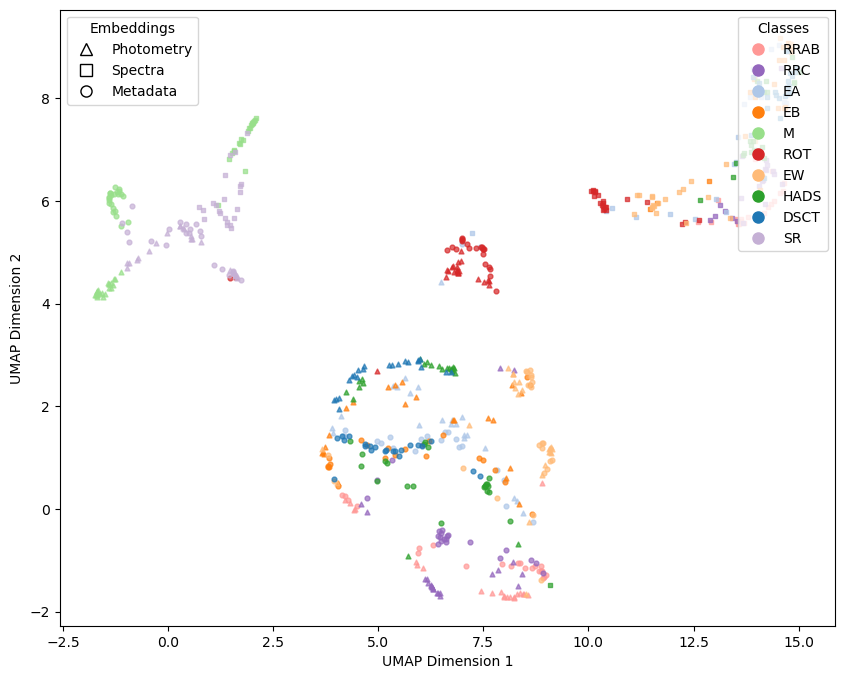

In [20]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', n_jobs=16)
size = 220
combined_emb = torch.vstack([p_emb[:size], s_emb[:size], m_emb[:size]])
combined_emb_umap = umap_model.fit_transform(combined_emb)

p_umap = combined_emb_umap[:size]
s_umap = combined_emb_umap[size:size * 2]
m_umap = combined_emb_umap[size * 2:]

plot_three_embs(p_umap, s_umap, m_umap, labels[:size])

In [136]:
i = 0
p_emb[i] @ s_emb[i], s_emb[i] @ m_emb[i], m_emb[i] @ p_emb[i]

(tensor(0.3357), tensor(0.4780), tensor(0.6628))

In [173]:
for label in range(10):
    ind = labels == label
    print((m_emb[ind] @ m_emb[ind].T).mean())

tensor(0.5064)
tensor(0.2833)
tensor(0.2490)
tensor(0.2604)
tensor(0.4657)
tensor(0.7821)
tensor(0.4193)
tensor(0.4784)
tensor(0.4366)
tensor(0.3523)


In [206]:
for i in range(10):
    ind = labels == i
    center = m_emb[ind].mean(axis=0)
    center = center / center.norm()
    
    cos = m_emb[ind] @ center
    diff_cos = m_emb[~ind] @ center

    cos_mean = round(cos.mean().item(), 4)
    diff_cos_mean = round(diff_cos.mean().item(), 4)
    
    cos_25 = round(torch.quantile(cos, 0.25).item(), 4)
    cos_75 = round(torch.quantile(cos, 0.75).item(), 4)
    diff_cos_25 = round(torch.quantile(diff_cos, 0.25).item(), 4)
    diff_cos_75 = round(torch.quantile(diff_cos, 0.75).item(), 4)
    
    print(f"Class {i}:")
    print(f"   Cos mean: {cos_mean}, 25%: {cos_25}, 75%: {cos_75}")
    print(f"   Diff Cos: {diff_cos_mean}, 25%: {diff_cos_25}, 75%: {diff_cos_75}")

Class 0:
   Cos mean: 0.7116, 25%: 0.6045, 75%: 0.815
   Diff Cos: 0.1717, 25%: -0.0012, 75%: 0.3168
Class 1:
   Cos mean: 0.5323, 25%: 0.4787, 75%: 0.6408
   Diff Cos: 0.2306, 25%: 0.1003, 75%: 0.347
Class 2:
   Cos mean: 0.499, 25%: 0.4055, 75%: 0.6101
   Diff Cos: 0.2941, 25%: 0.1807, 75%: 0.3968
Class 3:
   Cos mean: 0.5103, 25%: 0.4142, 75%: 0.6237
   Diff Cos: 0.2133, 25%: 0.1059, 75%: 0.3097
Class 4:
   Cos mean: 0.6824, 25%: 0.5841, 75%: 0.7619
   Diff Cos: 0.2223, 25%: 0.1097, 75%: 0.3036
Class 5:
   Cos mean: 0.8843, 25%: 0.8731, 75%: 0.9297
   Diff Cos: 0.0879, 25%: -0.0396, 75%: 0.1637
Class 6:
   Cos mean: 0.6476, 25%: 0.5748, 75%: 0.7348
   Diff Cos: 0.1889, 25%: 0.0622, 75%: 0.3056
Class 7:
   Cos mean: 0.6916, 25%: 0.6063, 75%: 0.796
   Diff Cos: 0.1631, 25%: 0.0262, 75%: 0.2761
Class 8:
   Cos mean: 0.6608, 25%: 0.5684, 75%: 0.7897
   Diff Cos: 0.2319, 25%: 0.1036, 75%: 0.3381
Class 9:
   Cos mean: 0.5935, 25%: 0.5386, 75%: 0.6574
   Diff Cos: 0.1725, 25%: 0.1045, 75%:

In [128]:
ps.shape

torch.Size([2225, 2225])

In [153]:
_, pred_labels = torch.max(mp, dim=1)
pred_labels.shape

torch.Size([2225])

In [154]:
m = torch.zeros(mp.shape)

In [155]:
for i in range(len(m)):
    m[i][pred_labels[i]] = 1

<Axes: >

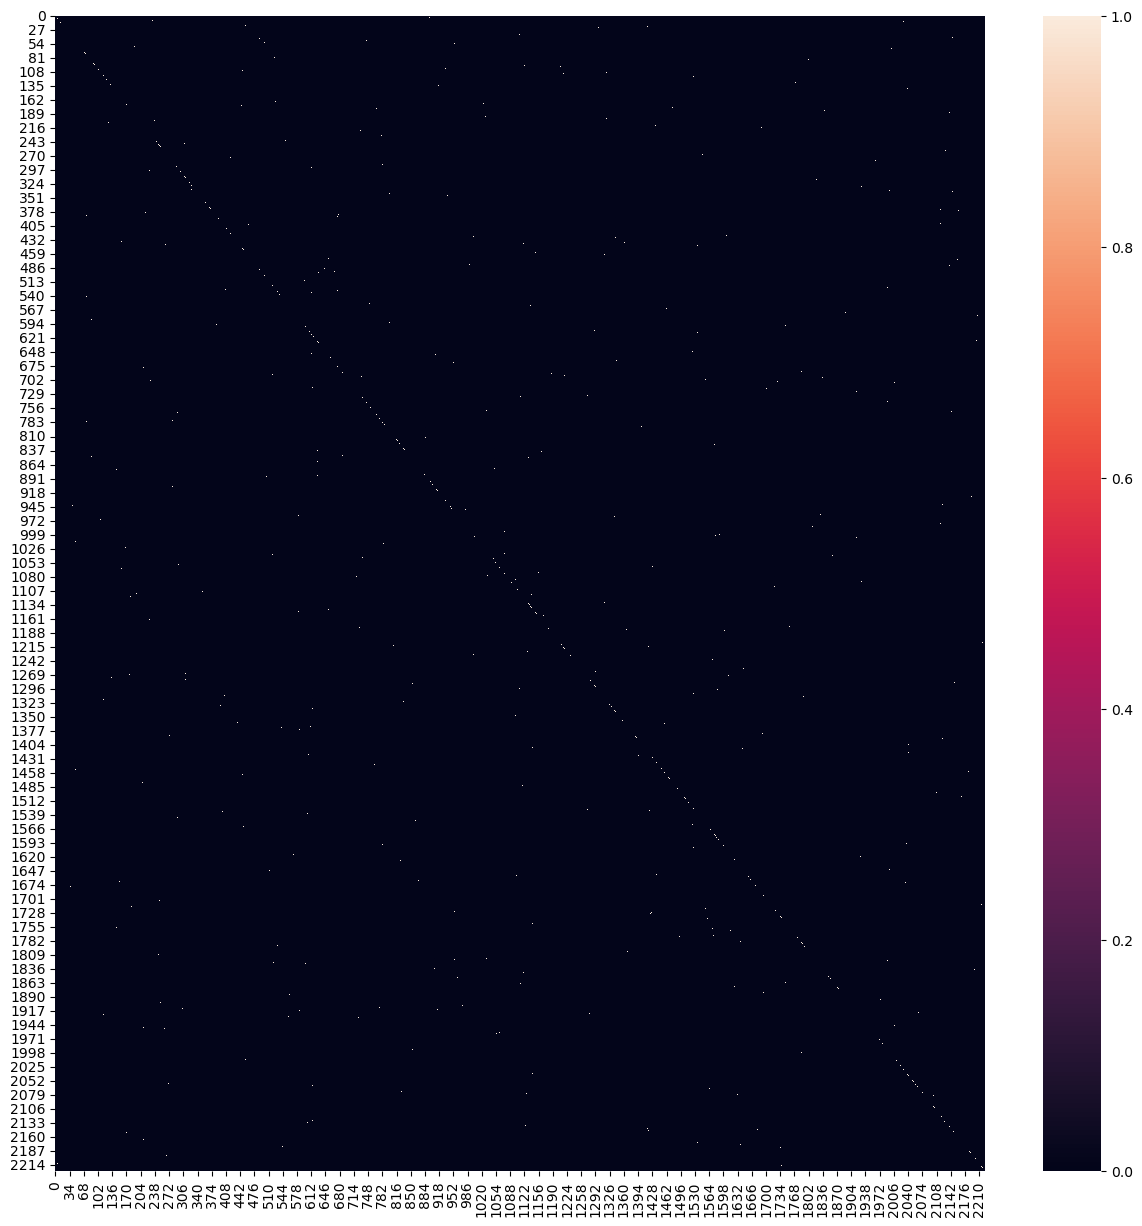

In [159]:
plt.figure(figsize=(15, 15))
sns.heatmap(m, annot=False)

In [14]:
def plot_dist(emb, labels, cls, emb_name):
    emb_cls = emb[labels == cls]
    center = emb_cls.mean(dim=0).unsqueeze(dim=0)
    center = center / center.norm()
    distances = cdist(emb_cls, center, metric='cosine')
    
    plt.hist(distances, bins=30, alpha=0.7, color='skyblue')
    plt.title(f'{emb_name} Embeddings: Class {cls}')
    plt.xlabel('Cosine Distance')
    plt.ylabel('Frequency')
    plt.grid(True)

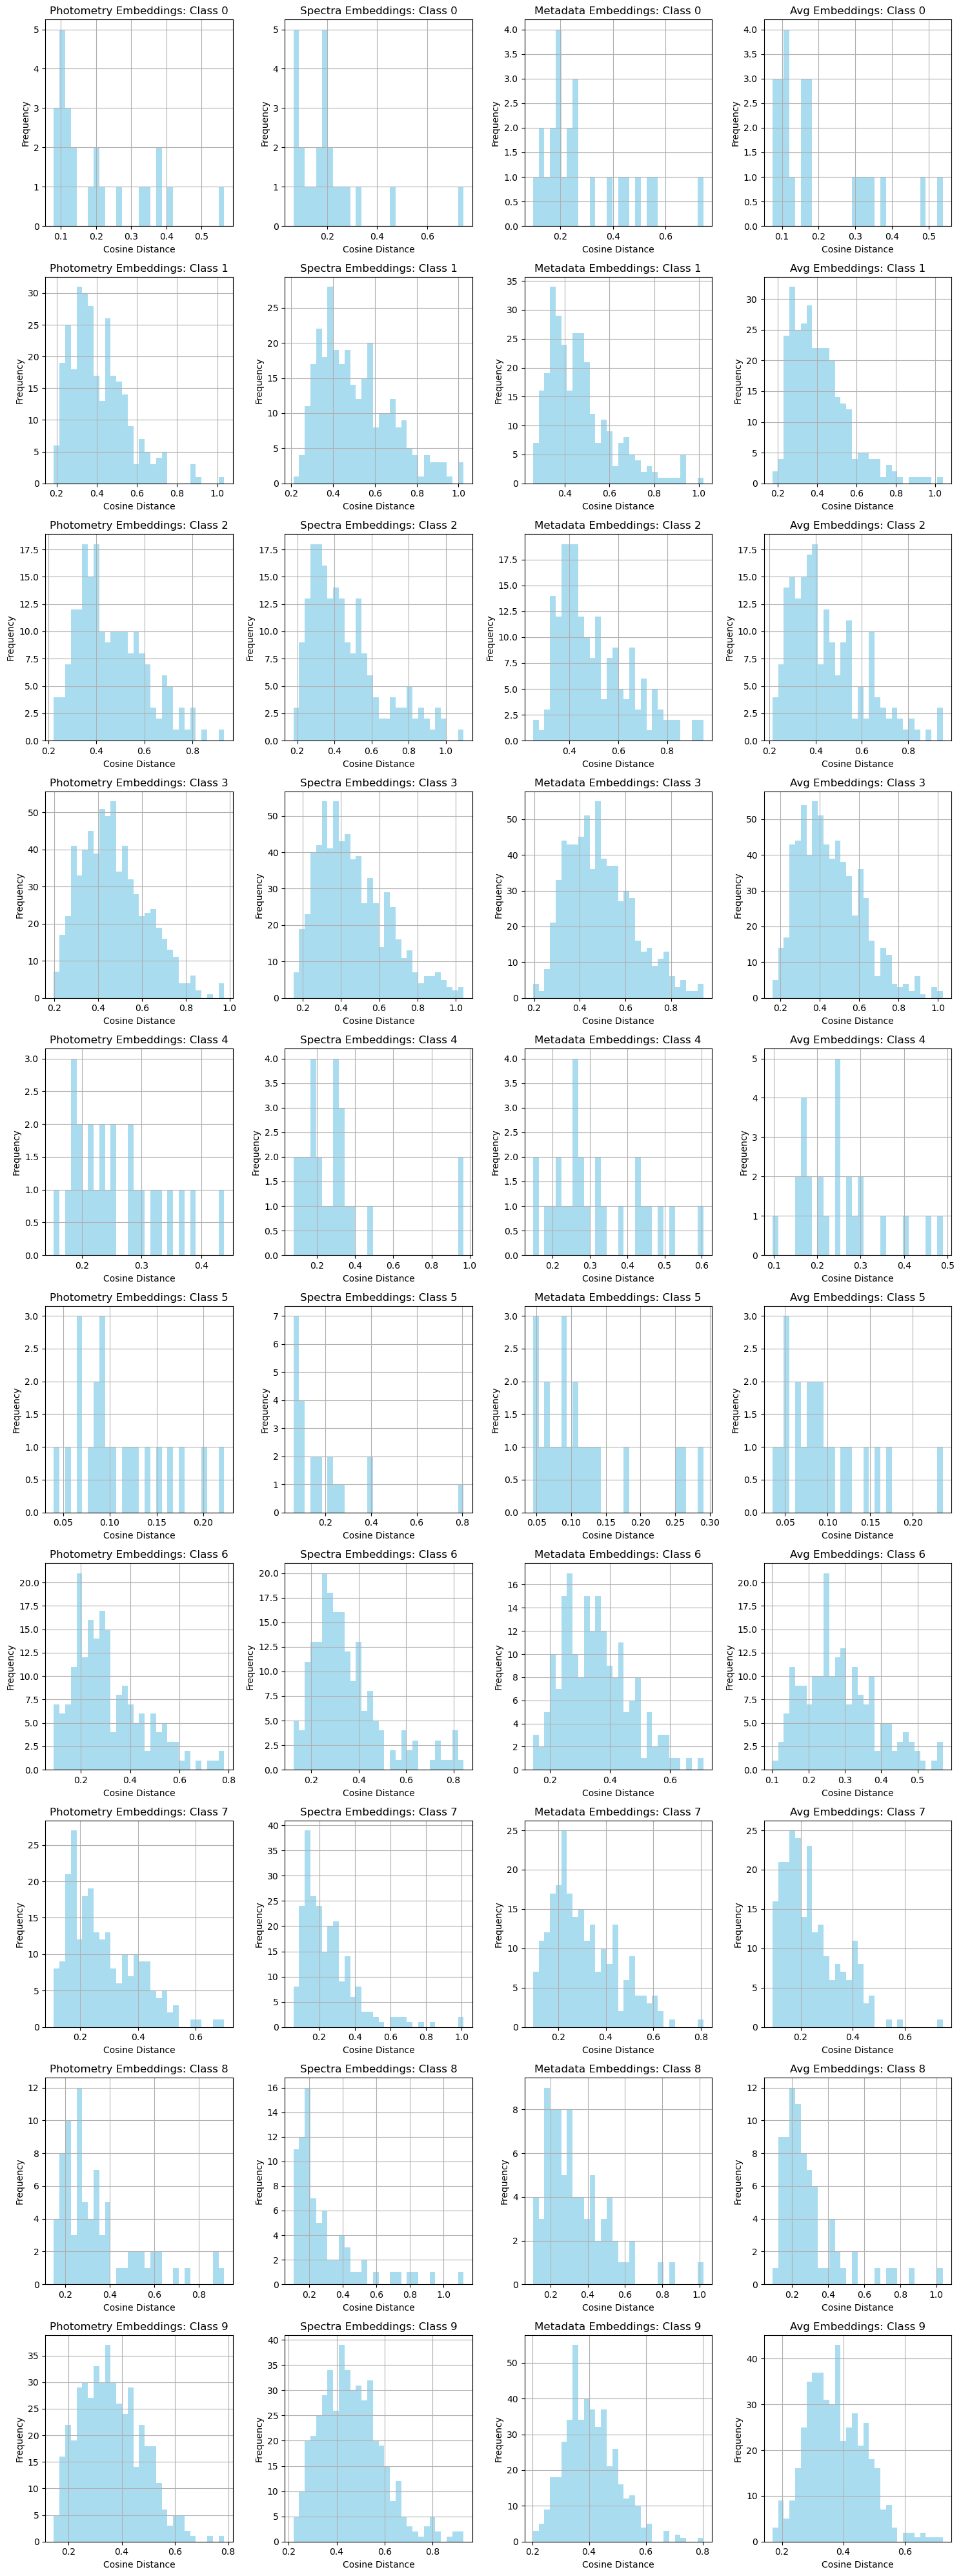

In [15]:
classes = range(10)

fig, axes = plt.subplots(len(classes), 4, figsize=(15, len(classes) * 4))
fig.tight_layout(pad=5.0)

for i, cls in enumerate(classes):
    plt.subplot(len(classes), 4, i * 4 + 1)
    plot_dist(p_emb, labels, cls, 'Photometry')
    
    plt.subplot(len(classes), 4, i * 4 + 2)
    plot_dist(s_emb, labels, cls, 'Spectra')
    
    plt.subplot(len(classes), 4, i * 4 + 3)
    plot_dist(m_emb, labels, cls, 'Metadata')

    plt.subplot(len(classes), 4, i * 4 + 4)
    plot_dist(emb, labels, cls, 'Avg')

plt.tight_layout()
plt.show()

In [16]:
def find_class_outliers(emb, labels, cls, threshold):
    emb_cls = emb[labels == cls]
    center = emb_cls.mean(dim=0).unsqueeze(dim=0)
    center = center / center.norm()
    distances = cdist(emb_cls, center, metric='cosine')
    
    outliers_cls = distances > threshold
    outliers_mask = torch.zeros(len(labels), dtype=torch.bool)
    outliers_mask[labels == cls] = torch.tensor(outliers_cls.flatten(), dtype=torch.bool)
    
    return outliers_mask

In [26]:
p_outliers = torch.zeros(len(labels), dtype=torch.bool)
s_outliers = torch.zeros(len(labels), dtype=torch.bool)
m_outliers = torch.zeros(len(labels), dtype=torch.bool)
threshold = 0.7

for cls in range(10):
    outliers_cls = find_class_outliers(p_emb, labels, cls, threshold)
    p_outliers |= outliers_cls
    
    outliers_cls = find_class_outliers(s_emb, labels, cls, threshold)
    s_outliers |= outliers_cls
    
    outliers_cls = find_class_outliers(m_emb, labels, cls, threshold)
    m_outliers |= outliers_cls

In [27]:
p_outliers.sum() / len(p_outliers), s_outliers.sum() / len(s_outliers), m_outliers.sum() / len(m_outliers)

(tensor(0.0427), tensor(0.0867), tensor(0.0553))

In [32]:
def plot_one_embs_outliers(embeddings, targets, outliers):
    plt.figure(figsize=(10, 8))
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id

        highlight_class_mask = class_mask & outliers

        plt.scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=0.7, s=marker_size)
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        highlight_class_mask = class_mask & outliers

        plt.scatter(embeddings[highlight_class_mask, 0], embeddings[highlight_class_mask, 1], 
                    color=palette[class_id], alpha=0.7, s=marker_size, edgecolor='black', linewidth=1)
    
    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    plt.legend(handles=handles_colors, loc='upper right', fontsize=10, title="Classes")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

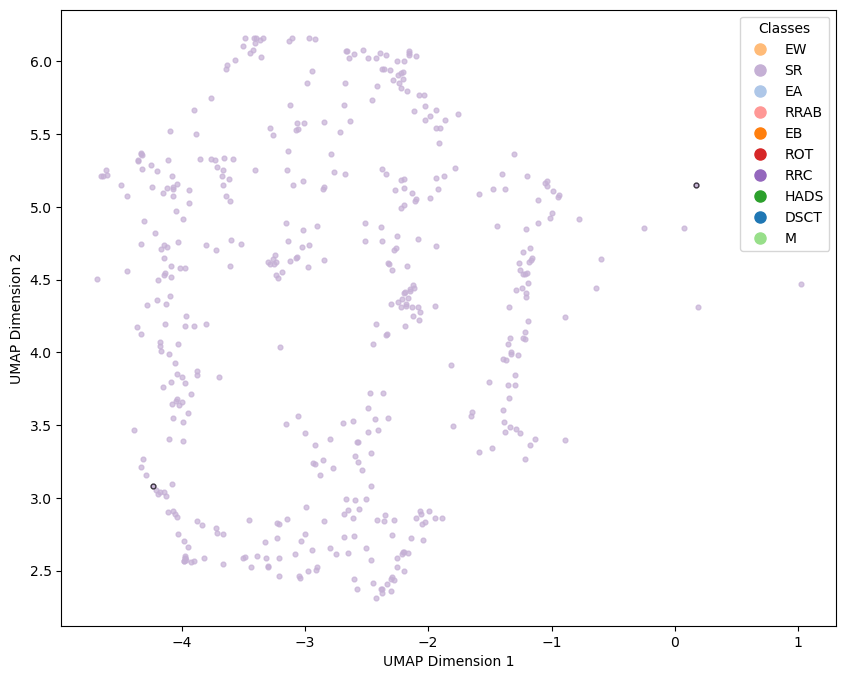

In [47]:
ind = labels == 9
plot_one_embs_outliers(p_emb_umap[ind], labels[ind], p_outliers[ind])

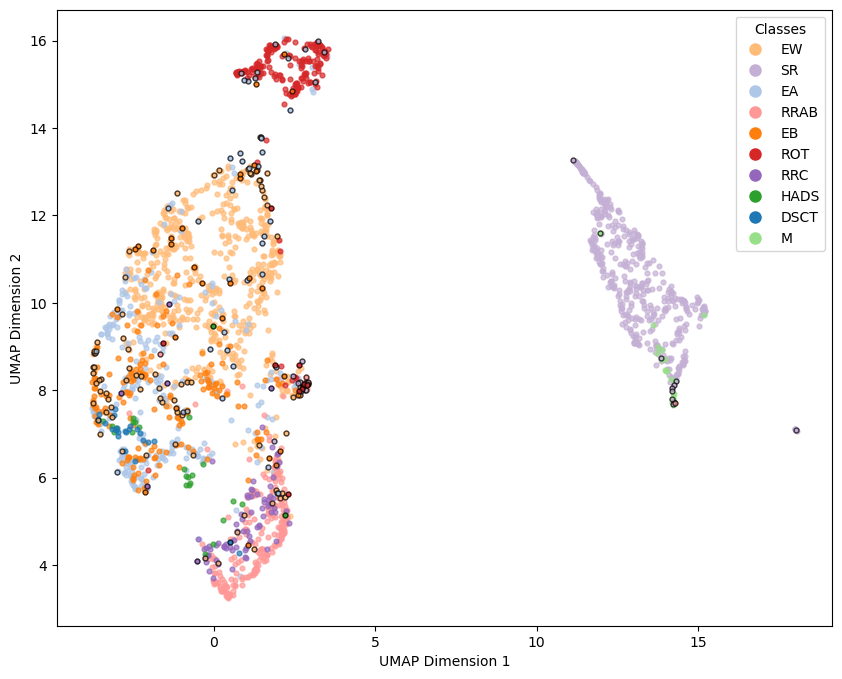

In [34]:
plot_one_embs_outliers(s_emb_umap, labels, s_outliers)

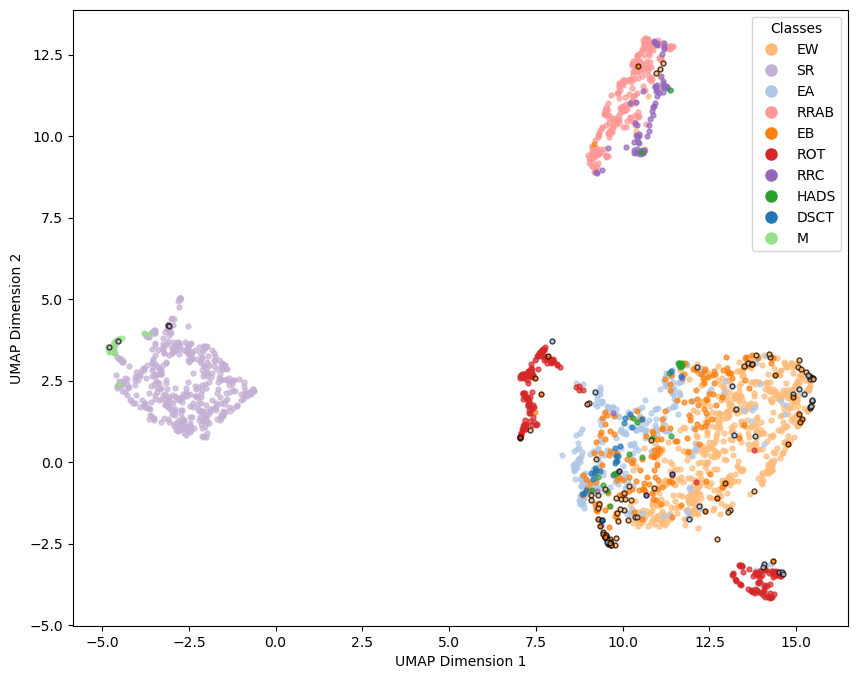

In [35]:
plot_one_embs_outliers(m_emb_umap, labels, m_outliers)

In [10]:
p_emb, s_emb, m_emb = p_emb.cpu(), s_emb.cpu(), m_emb.cpu()

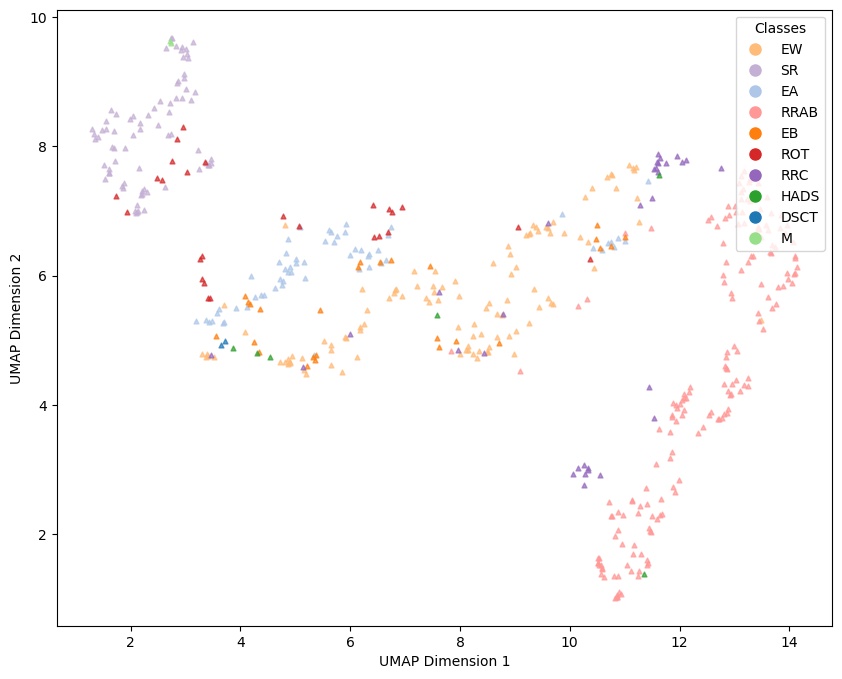

In [24]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
p_emb_umap = umap_model.fit_transform(p_emb)
plot_one_embs(p_emb_umap, labels)

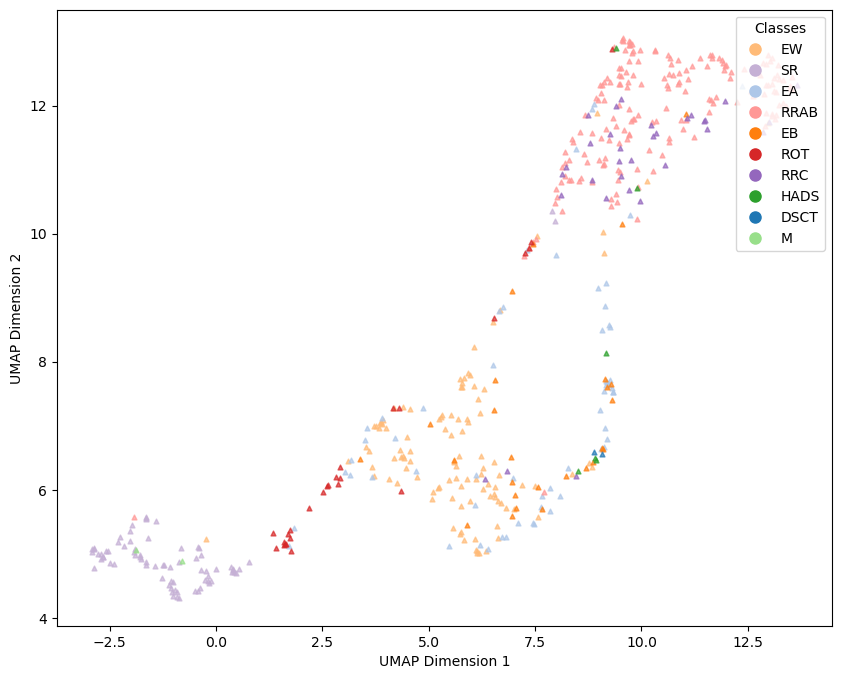

In [25]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
s_emb_umap = umap_model.fit_transform(s_emb)
plot_one_embs(s_emb_umap, labels)

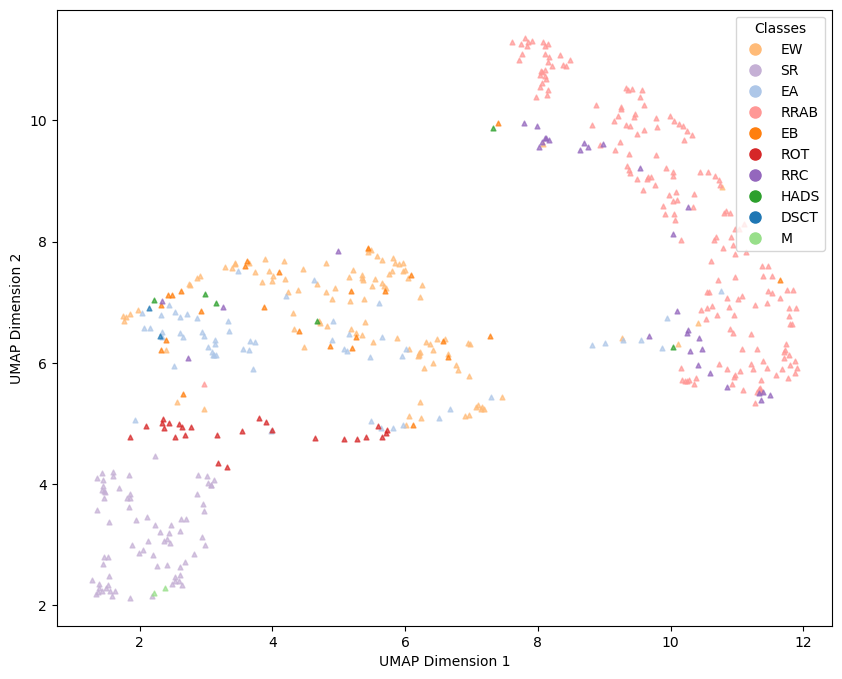

In [26]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
m_emb_umap = umap_model.fit_transform(m_emb)
plot_one_embs(m_emb_umap, labels)

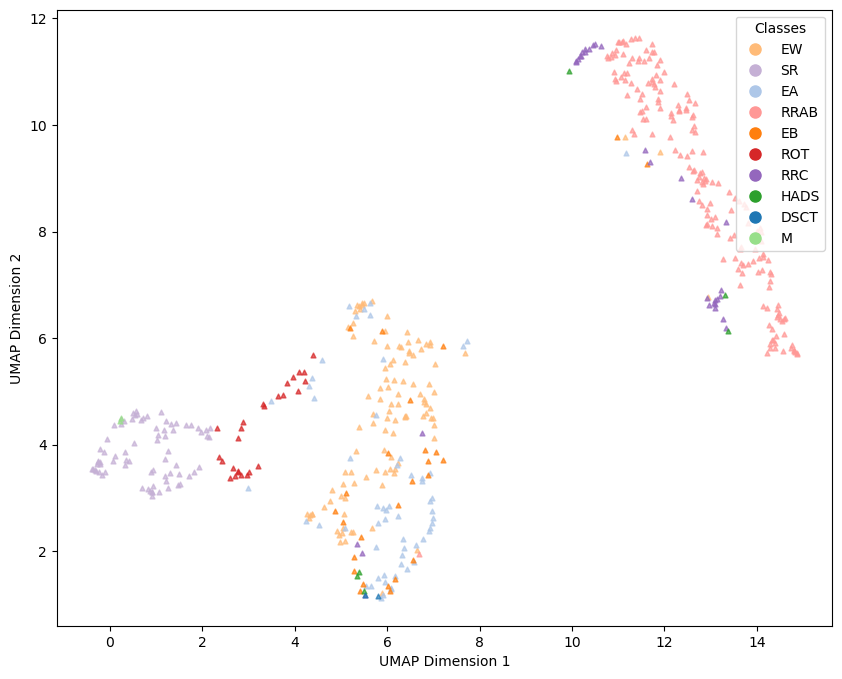

In [60]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
emb = (p_emb + s_emb + m_emb) / 3
emb_umap = umap_model.fit_transform(emb)
plot_one_embs(emb_umap, labels)

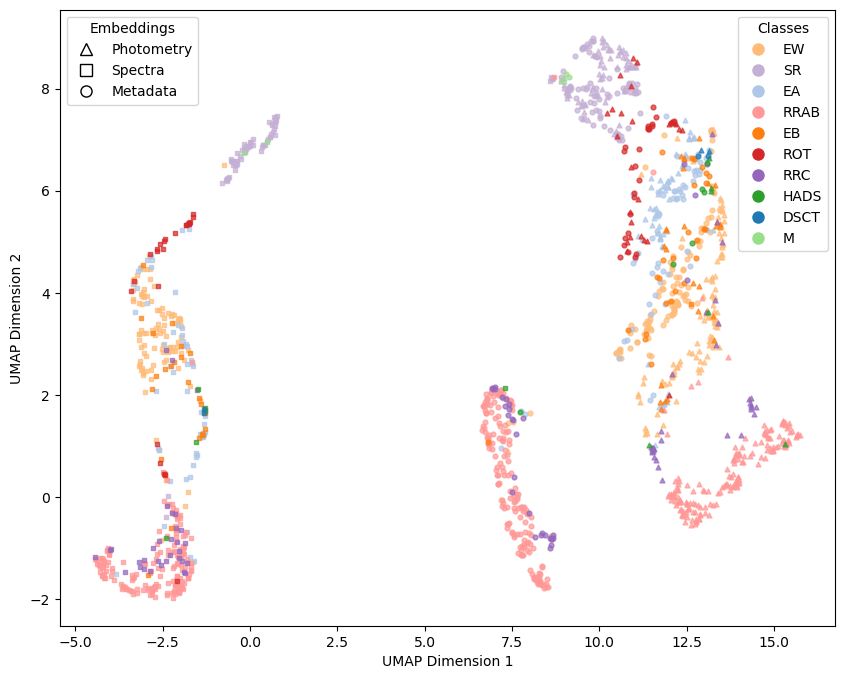

In [30]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
combined_emb = torch.vstack([p_emb, s_emb, m_emb])
combined_emb_umap = umap_model.fit_transform(combined_emb)

p_umap = combined_emb_umap[:len(p_emb)]
s_umap = combined_emb_umap[len(p_emb):len(p_emb) + len(s_emb)]
m_umap = combined_emb_umap[len(p_emb) + len(s_emb):]

plot_three_embs(p_umap, s_umap, m_umap, labels)

In [31]:
prob_ps = (F.softmax(logits_ps, dim=1) + F.softmax(logits_ps.transpose(-1, -2), dim=1)) / 2
prob_sm = (F.softmax(logits_sm, dim=1) + F.softmax(logits_sm.transpose(-1, -2), dim=1)) / 2
prob_mp = (F.softmax(logits_mp, dim=1) + F.softmax(logits_mp.transpose(-1, -2), dim=1)) / 2
prob = (prob_ps + prob_sm + prob_mp) / 3

In [32]:
_, pred_labels = torch.max(prob, dim=1)
pred_labels = pred_labels.cpu()
y = torch.arange(logits_ps.shape[0], dtype=torch.int64)
correct_predictions = (y == pred_labels).sum().item()
correct_predictions

298

In [61]:
_, pred_labels_ps = torch.max(prob_ps, dim=1)
pred_labels_ps = pred_labels_ps.cpu()
y = torch.arange(logits_ps.shape[0], dtype=torch.int64)
correct_ps = (y == pred_labels_ps).sum().item()

_, pred_labels_sm = torch.max(prob_sm, dim=1)
pred_labels_sm = pred_labels_sm.cpu()
y = torch.arange(logits_sm.shape[0], dtype=torch.int64)
correct_sm = (y == pred_labels_sm).sum().item()

_, pred_labels_mp = torch.max(prob_mp, dim=1)
pred_labels_mp = pred_labels_mp.cpu()
y = torch.arange(logits_mp.shape[0], dtype=torch.int64)
correct_mp = (y == pred_labels_mp).sum().item()

correct_ps, correct_sm, correct_mp

(77, 177, 268)

In [36]:
incorrect_mask = (y == pred_labels)

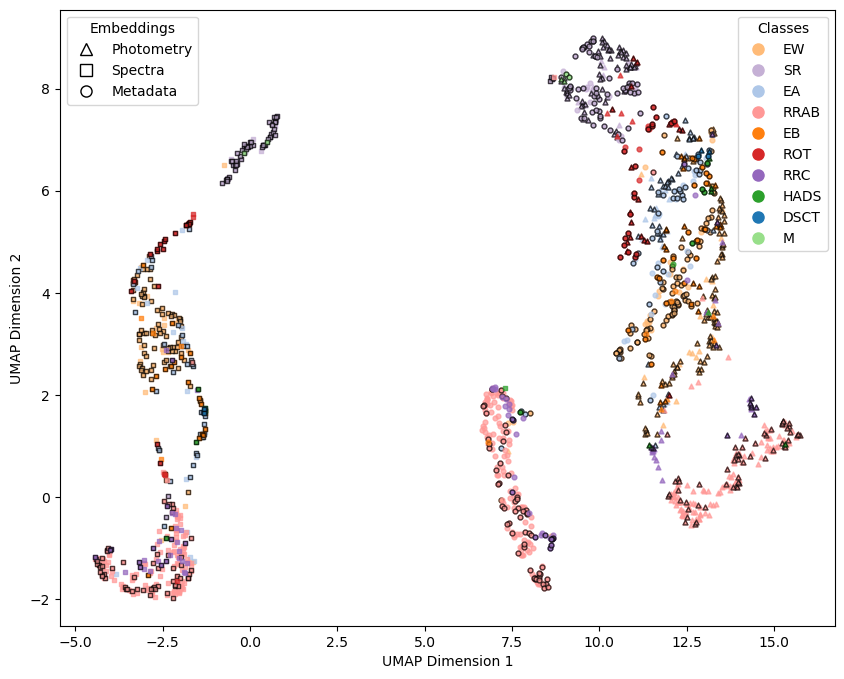

In [39]:
plot_three_embs_mask(p_umap, s_umap, m_umap, labels, incorrect_mask)

In [40]:
top3_prob, top3_pred_labels = torch.topk(prob, k=3, dim=1)
top3_pred_labels = top3_pred_labels.cpu()
y = torch.arange(logits_ps.shape[0], dtype=torch.int64)
top3_correct = top3_pred_labels.eq(y.unsqueeze(1)).sum().item()
top3_correct

395

In [56]:
top3_inc_mask = ~top3_pred_labels.eq(y.unsqueeze(1)).any(dim=1)

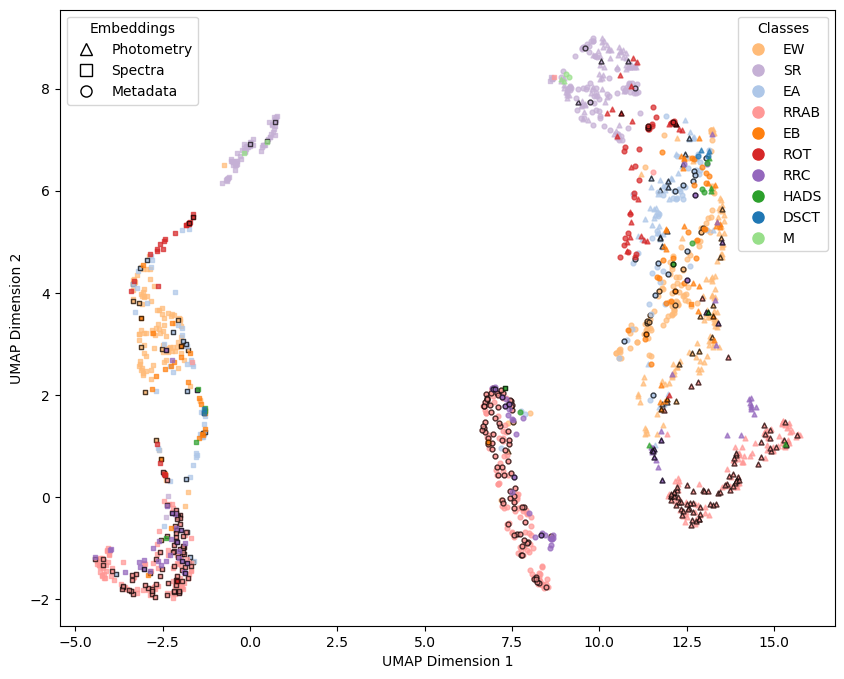

In [57]:
plot_three_embs_mask(p_umap, s_umap, m_umap, labels, top3_inc_mask)

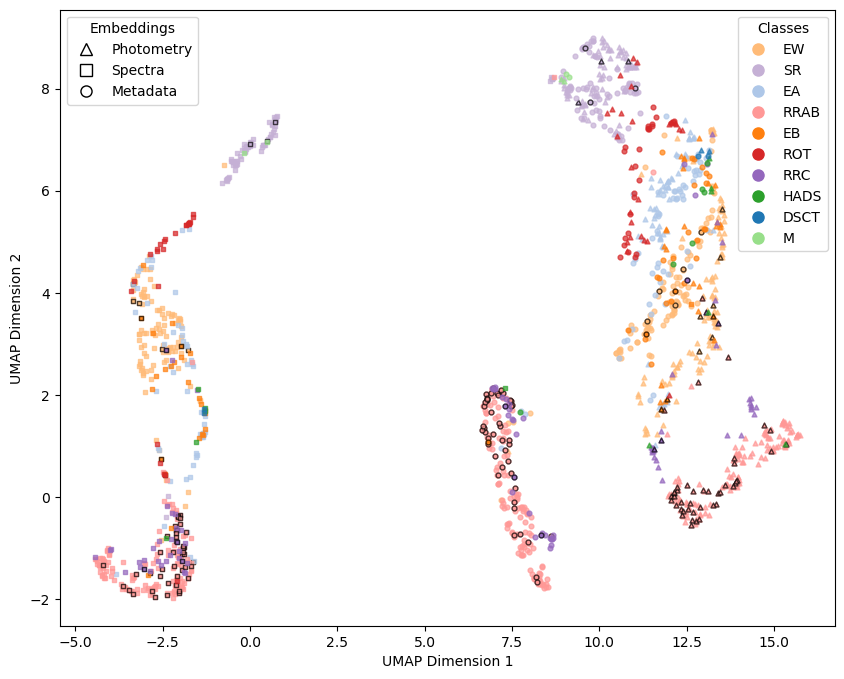

In [58]:
top3_prob, top3_pred_labels = torch.topk(prob, k=10, dim=1)
top3_pred_labels = top3_pred_labels.cpu()
y = torch.arange(logits_ps.shape[0], dtype=torch.int64)
top3_correct = top3_pred_labels.eq(y.unsqueeze(1)).sum().item()
top3_inc_mask = ~top3_pred_labels.eq(y.unsqueeze(1)).any(dim=1)
plot_three_embs_mask(p_umap, s_umap, m_umap, labels, top3_inc_mask)

In [5]:
p_embs, s_embs, m_embs, labels = [], [], [], []

with torch.no_grad():
    for photometry, photometry_mask, spectra, metadata, label in test_dataloader:
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)

        p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
        p_embs.append(p_emb.cpu())
        s_embs.append(s_emb.cpu())
        m_embs.append(m_emb.cpu())
        labels.append(label)

p_embs = torch.vstack(p_embs)
s_embs = torch.vstack(s_embs)
m_embs = torch.vstack(m_embs)
labels = torch.hstack(labels)

In [6]:
p_embs.shape, s_embs.shape, m_embs.shape, labels.shape

(torch.Size([2225, 512]),
 torch.Size([2225, 512]),
 torch.Size([2225, 512]),
 torch.Size([2225]))

In [ ]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
p_embs_umap = umap_model.fit_transform(p_embs)
s_embs_umap = umap_model.fit_transform(s_embs)
m_embs_umap = umap_model.fit_transform(m_embs)

In [ ]:
plot_one_embs(p_embs_umap)

In [ ]:
plot_one_embs(s_embs_umap)

In [ ]:
plot_one_embs(m_embs_umap)

In [ ]:
combined_embs = torch.vstack([p_embs, s_embs, m_embs])
print(combined_embs.shape)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
combined_embs_umap = umap_model.fit_transform(combined_embs)
print(combined_embs_umap.shape)

p_embs_umap = combined_embs_umap[:len(p_embs)]
s_embs_umap = combined_embs_umap[len(p_embs):len(p_embs) + len(s_embs)]
m_embs_umap = combined_embs_umap[len(p_embs) + len(s_embs):]

In [ ]:
plot_three_embs(p_embs_umap, s_embs_umap, m_embs_umap)

In [ ]:
photometry, photometry_mask, spectra, metadata, label = next(iter(test_dataloader))
photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
spectra, metadata = spectra.to(device), metadata.to(device)

In [ ]:
p_emb = model.photometry_proj(model.photometry_encoder(photometry, photometry_mask))
s_emb = model.spectra_proj(model.spectra_encoder(spectra))
m_emb = model.metadata_proj(model.metadata_encoder(metadata))

In [ ]:
p_embs_nonorm, s_embs_nonorm, m_embs_nonorm, labels = [], [], [], []

with torch.no_grad():
    for photometry, photometry_mask, spectra, metadata, label in test_dataloader:
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)

        p_emb = model.photometry_proj(model.photometry_encoder(photometry, photometry_mask))
        s_emb = model.spectra_proj(model.spectra_encoder(spectra))
        m_emb = model.metadata_proj(model.metadata_encoder(metadata))

        p_embs_nonorm.append(p_emb.cpu())
        s_embs_nonorm.append(s_emb.cpu())
        m_embs_nonorm.append(m_emb.cpu())
        labels.append(label)

p_embs_nonorm = torch.vstack(p_embs_nonorm)
s_embs_nonorm = torch.vstack(s_embs_nonorm)
m_embs_nonorm = torch.vstack(m_embs_nonorm)
labels = torch.hstack(labels)

In [ ]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
p_embs_nonorm_umap = umap_model.fit_transform(p_embs_nonorm)

In [ ]:
plot_one_embs(p_embs_nonorm_umap)

In [ ]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
s_embs_nonorm_umap = umap_model.fit_transform(s_embs_nonorm)

In [ ]:
plot_one_embs(s_embs_nonorm_umap)

In [ ]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
m_embs_nonorm_umap = umap_model.fit_transform(m_embs_nonorm)

In [ ]:
plot_one_embs(m_embs_nonorm_umap)

In [ ]:
combined_embs_nonorm = torch.vstack([p_embs_nonorm, s_embs_nonorm, m_embs_nonorm])
print(combined_embs_nonorm.shape)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
combined_embs_nonorm_umap = umap_model.fit_transform(combined_embs_nonorm)
print(combined_embs_nonorm_umap.shape)

p_emb_umap = combined_embs_nonorm_umap[:len(p_embs)]
s_embs_umap = combined_embs_nonorm_umap[len(p_embs):len(p_embs) + len(s_embs)]
m_embs_umap = combined_embs_nonorm_umap[len(p_embs) + len(s_embs):]

In [ ]:
plot_three_embs(p_embs_umap, s_embs_umap, m_embs_umap)

In [109]:
model.logit_scale_ps, model.logit_scale_sm, model.logit_scale_mp

(Parameter containing:
 tensor(3.1638, device='cuda:1', requires_grad=True),
 Parameter containing:
 tensor(3.4750, device='cuda:1', requires_grad=True),
 Parameter containing:
 tensor(3.7970, device='cuda:1', requires_grad=True))

In [121]:
photometry, photometry_mask, spectra, metadata, labels = next(iter(test_dataloader))
photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
spectra, metadata = spectra.to(device), metadata.to(device)

with torch.no_grad():
    p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)

    logit_scale_ps = torch.clamp(model.logit_scale_ps.exp(), min=1, max=100)
    logit_scale_sm = torch.clamp(model.logit_scale_sm.exp(), min=1, max=100)
    logit_scale_mp = torch.clamp(model.logit_scale_mp.exp(), min=1, max=100)

    logits_ps = logit_scale_ps * p_emb @ s_emb.T
    logits_sm = logit_scale_sm * s_emb @ m_emb.T
    logits_mp = logit_scale_mp * m_emb @ p_emb.T

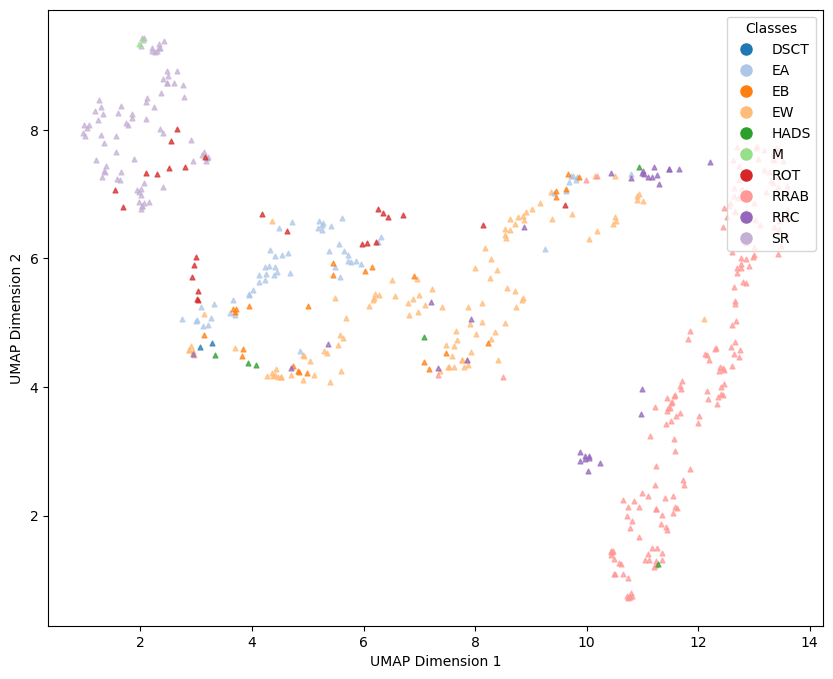

In [122]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
p_embs_umap = umap_model.fit_transform(p_emb.cpu())
plot_one_embs(p_embs_umap)

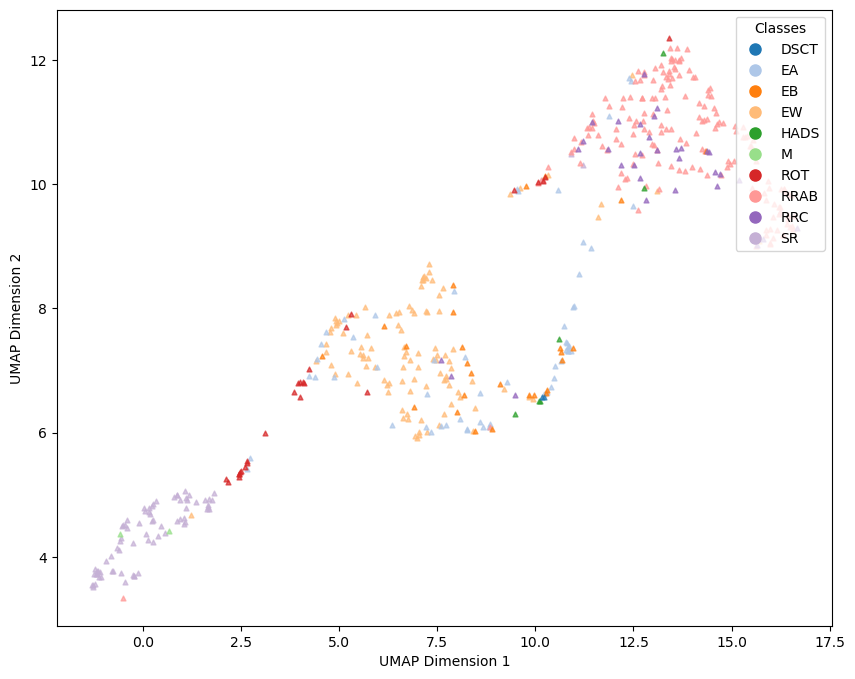

In [123]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
s_embs_umap = umap_model.fit_transform(s_emb.cpu())
plot_one_embs(s_embs_umap)

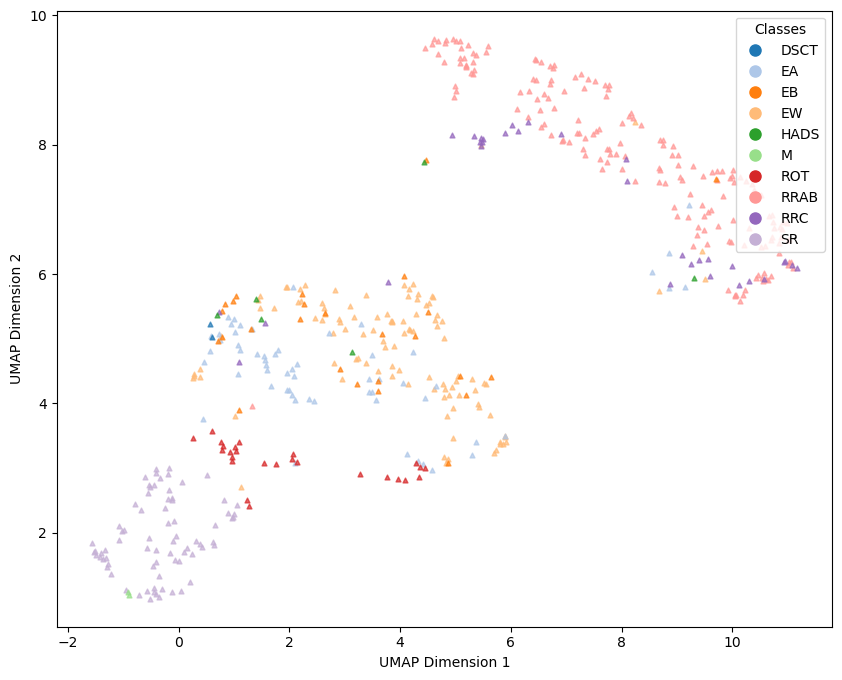

In [124]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
m_embs_umap = umap_model.fit_transform(m_emb.cpu())
plot_one_embs(m_embs_umap)

torch.Size([1536, 512])
(1536, 2)


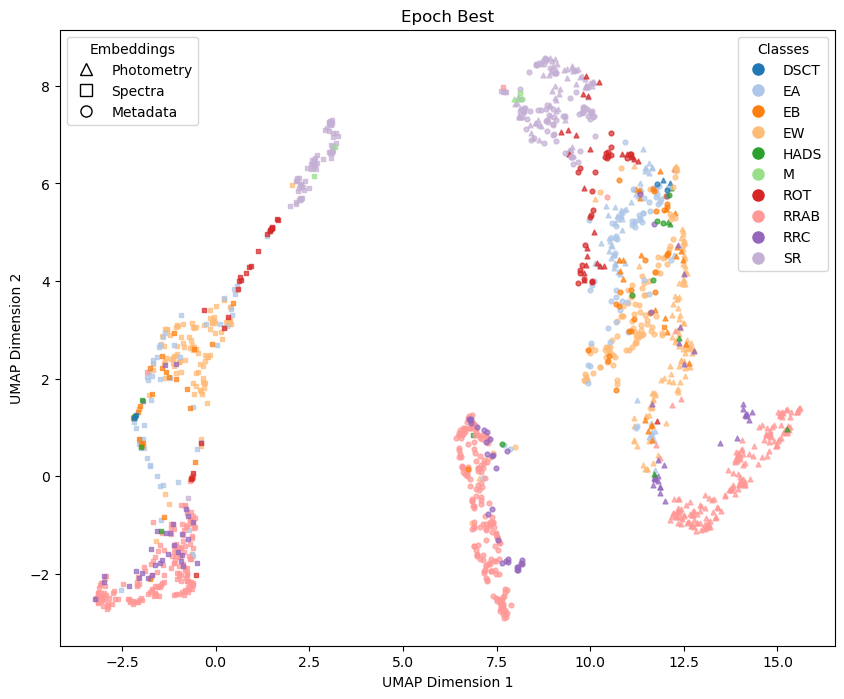

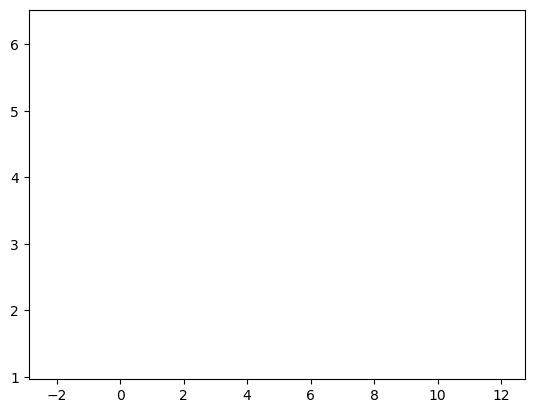

In [130]:
combined_embs = torch.vstack([p_emb.cpu(), s_emb.cpu(), m_emb.cpu()])
print(combined_embs.shape)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', n_jobs=16)
combined_embs_umap = umap_model.fit_transform(combined_embs)
print(combined_embs_umap.shape)

p_embs_umap = combined_embs_umap[:len(p_emb)]
s_embs_umap = combined_embs_umap[len(p_emb):len(p_emb) + len(s_emb)]
m_embs_umap = combined_embs_umap[len(p_emb) + len(s_emb):]

plot_three_embs(p_embs_umap, s_embs_umap, m_embs_umap)

plt.plot(p_embs_umap[0][0], p_embs_umap[0][1])
plt.plot(s_embs_umap[0][0], s_embs_umap[0][1])
plt.plot(m_embs_umap[0][0], m_embs_umap[0][1])

In [128]:
p_emb_umap

array([[12.948844 ,  7.0752454],
       [12.451513 ,  6.5567207],
       [10.94751  ,  6.9706163],
       ...,
       [13.853053 ,  5.766955 ],
       [10.229183 ,  8.253343 ],
       [ 8.919409 ,  7.420509 ]], dtype=float32)

In [113]:
prob_ps = (F.softmax(logits_ps, dim=1) + F.softmax(logits_ps.transpose(-1, -2), dim=1)) / 2
prob_sm = (F.softmax(logits_sm, dim=1) + F.softmax(logits_sm.transpose(-1, -2), dim=1)) / 2
prob_mp = (F.softmax(logits_mp, dim=1) + F.softmax(logits_mp.transpose(-1, -2), dim=1)) / 2
prob = (prob_ps + prob_sm + prob_mp) / 3

In [114]:
_, pred_labels = torch.max(prob, dim=1)
pred_labels = pred_labels.cpu()
y = torch.arange(logits_ps.shape[0], dtype=torch.int64)
correct_predictions = (y == pred_labels).sum().item()

In [115]:
val_match, c_match = torch.unique(labels[:512][y == pred_labels], return_counts=True)

In [116]:
val_nomatch, c_nomatch = torch.unique(labels[:512][y != pred_labels], return_counts=True)

In [117]:
print("Class   | Match   | No Match")
print("----------------------------")

for i in range(10):
    match = c_match[i].item()

    if i == 0 or i == 5:
        nomatch = 0
    elif i < 5:
        nomatch = c_nomatch[i - 1].item()
    else:
        nomatch = c_nomatch[i - 2].item()

    cl = id2target[i]
    
    print(f"{cl:<7} | {match:<7} | {nomatch:<8}")

Class   | Match   | No Match
----------------------------
DSCT    | 2       | 0       
EA      | 37      | 22      
EB      | 22      | 4       
EW      | 84      | 24      
HADS    | 5       | 1       
M       | 2       | 0       
ROT     | 19      | 7       
RRAB    | 56      | 120     
RRC     | 12      | 20      
SR      | 59      | 16      


In [118]:
for k in range(1, 10):
    top3_prob, top3_pred_labels = torch.topk(prob, k=k, dim=1)
    top3_pred_labels = top3_pred_labels.cpu()
    y = torch.arange(logits_ps.shape[0], dtype=torch.int64)
    top3_correct = top3_pred_labels.eq(y.unsqueeze(1)).sum().item()
    print('Top', k, top3_correct)

Top 1 298
Top 2 363
Top 3 395
Top 4 417
Top 5 421
Top 6 433
Top 7 441
Top 8 445
Top 9 448


In [102]:
true_labels = labels[:512]

In [106]:
y[true_labels == 1], pred_labels[true_labels == 1]

(tensor([  5,  10,  16,  32,  36,  43,  44,  47,  50,  51,  54,  56,  61,  64,
          65,  68,  74,  79,  86,  87,  89,  92, 102, 103, 108, 109, 111, 118,
         119, 120, 122, 154, 192, 194, 196, 209, 215, 220, 231, 243, 251, 254,
         276, 290, 362, 367, 381, 385, 398, 426, 434, 437, 446, 471, 479, 493,
         501, 503, 504]),
 tensor([ 61,  15,  16,  32,  36, 168,  44,  47,  50,  51, 122,  56,  61,  64,
          65, 503,  36, 135,  64,  87,  89,   8, 148, 103, 180, 109, 111, 119,
         119, 120, 122, 215, 192, 194, 194, 209, 215, 501, 231, 243, 251, 254,
         276, 290, 479, 367,  67, 466, 398, 426, 434, 437,  69, 471, 362, 115,
         501, 367, 504]))

tensor([  0,   1, 125,   3,   4,  61,   6, 106,   8,   9,  15,  11,  12,  13,
         93,  15,  16, 164,  11, 376,  20,  21,  22,  23,  24, 391,  26,  27,
         28,  29, 505, 248,  32,  33,  34,  35,  36, 262, 160, 363,  40,   4,
         42, 168,  44,  45,  46,  47,  48,  49,  50,  51,  52, 272, 122,  55,
         56,  93,  58,  59,  52,  61,  62,  84,  64,  65,  66,  67, 503,  69,
         70,  71,  72,  73,  36,  75,  76,  77,  78, 135,  80,  81,  82,  83,
         84,  85,  64,  87,  88,  89,  90,  91,   8,  14,  94,  95,  96,  97,
         98,  99, 114, 101, 148, 103, 104, 162, 106, 294, 180, 109, 110, 111,
        112, 113, 114, 115, 116, 195, 119, 119, 120,  84, 122, 123, 124, 125,
        126, 509, 438, 489, 130, 212, 507, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 153, 147, 148, 149, 178, 160, 356, 153,
        215, 155, 156, 157, 158, 159, 151, 161, 162, 163,  17, 165, 449,  77,
        168, 293, 282, 484, 172, 439, 174, 175, 379, 177, 193, 1

In [38]:
correct_predictions

298

In [42]:
len(labels[:512])

512

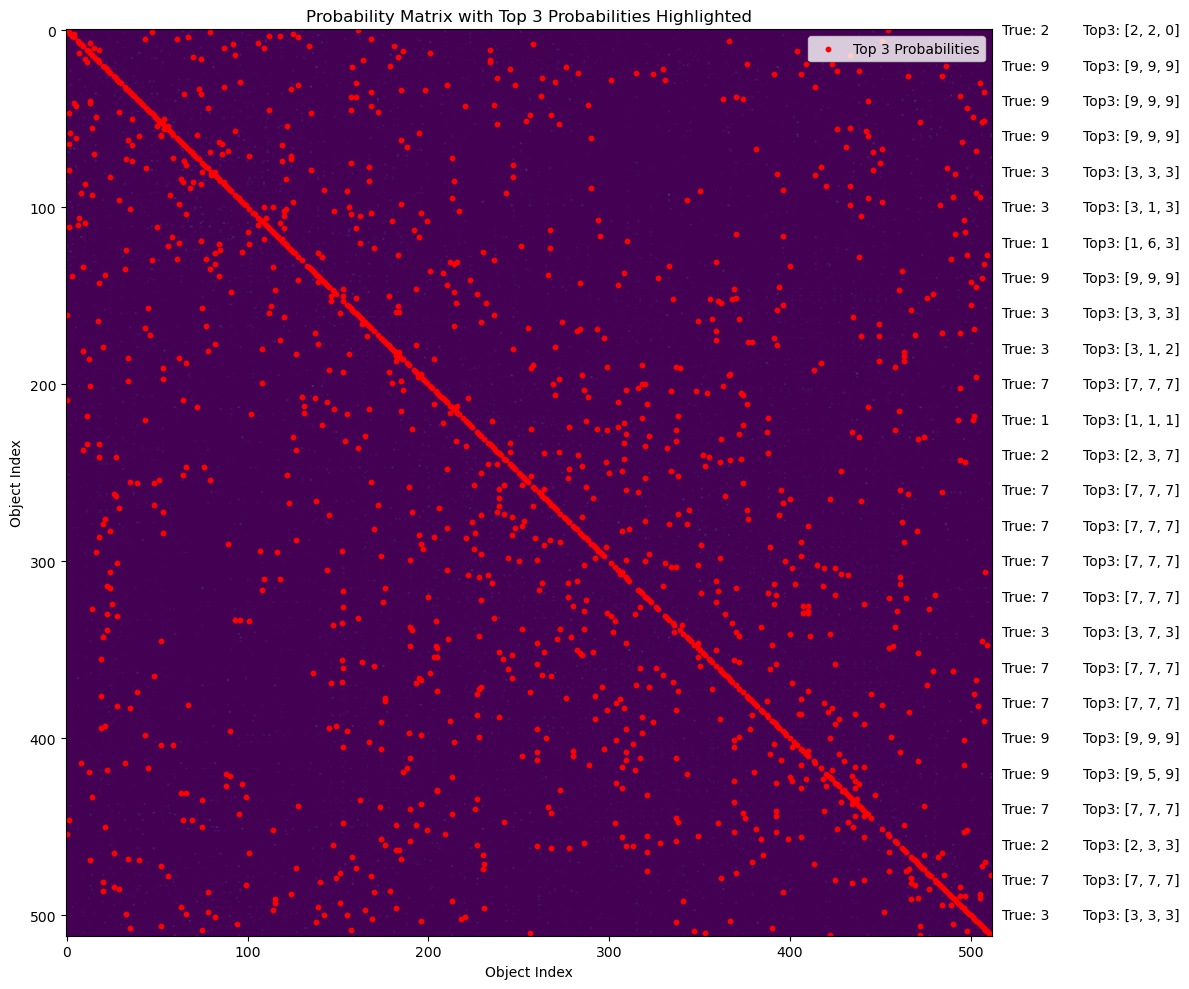

In [47]:
# Convert probabilities to NumPy array for easier processing
prob_np = prob.cpu().numpy()

# Find top 3 probabilities for each object
top_k = 3
topk_indices = np.argsort(-prob_np, axis=1)[:, :top_k]  # Indices of top 3 probs per row

# Prepare a mask for highlighting
mask = np.zeros_like(prob_np)
for i in range(prob_np.shape[0]):
    mask[i, topk_indices[i]] = 1

# Plot the probability matrix
plt.figure(figsize=(12, 10))
plt.imshow(prob_np, cmap='viridis', aspect='auto')
# plt.colorbar()

# Highlight the top 3 probabilities
# We will overlay red dots on the positions of the top 3 probabilities
rows = np.repeat(np.arange(prob_np.shape[0]), top_k)
cols = topk_indices.flatten()
plt.scatter(cols, rows, color='red', s=10, label='Top 3 Probabilities', marker='o')

plt.xlabel('Object Index')
plt.ylabel('Object Index')
plt.title('Probability Matrix with Top 3 Probabilities Highlighted')
plt.legend(loc='upper right')

# Optionally annotate a subset for clarity (e.g., every 50th object)
for i in range(0, prob_np.shape[0], 20):
    # True class label for the object
    true_class = labels[i]
    # Classes of the top 3 probabilities
    top_classes = labels[topk_indices[i]]
    plt.text(prob_np.shape[1] + 5, i, f'True: {true_class}', va='center')
    plt.text(prob_np.shape[1] + 50, i, f'Top3: {top_classes.tolist()}', va='center')

plt.tight_layout()
plt.show()

In [27]:
pca = PCA(n_components=32, random_state=42)
p_embs_pca = pca.fit_transform(p_embs)
pca.explained_variance_ratio_.sum()

0.9757979879636931

In [24]:
pca = PCA(n_components=32, random_state=42)
s_embs_pca = pca.fit_transform(s_embs)
pca.explained_variance_ratio_.sum()

0.940476586186524

In [25]:
pca = PCA(n_components=32, random_state=42)
m_embs_pca = pca.fit_transform(m_embs)
pca.explained_variance_ratio_.sum()

0.9407878664722573

In [28]:
tsne = TSNE(n_components=2, metric='cosine', n_jobs=16, random_state=42, verbose=True)
p_embs_2d = tsne.fit(p_embs_pca)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='cosine', n_jobs=16, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 0.49 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.04 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=185.42 for 250 iterations...
Iteration   50, KL divergence 3.1795, 50 iterations in 145.0958 sec


KeyboardInterrupt: 

In [20]:
tsne = TSNE(n_components=2, metric='cosine', n_jobs=16, random_state=42, verbose=True)
p_embs_2d = tsne.fit(p_embs_pca)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, metric='cosine', n_jobs=16, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 0.43 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.04 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=185.42 for 250 iterations...
Iteration   50, KL divergence 3.1917, 50 iterations in 145.1436 sec
Iteration  100, KL divergence 3.2669, 50 iterations in 140.3206 sec
Iteration  150, KL divergence 3.2733, 50 iterations in 140.5761 sec
Iteration  200, KL divergence 3.2738, 50 iterations in 141.1353 sec
Iteration  250, KL divergence 3.2739, 50 iterations in 139.3811 sec
   --> Time elapsed: 706.57 seconds
===> Running o

KeyboardInterrupt: 

In [ ]:
def plot_one_embs(embs_2d):
    plt.figure(figsize=(10, 8))
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = labels == class_id
        plt.scatter(embs_2d[class_mask, 0], embs_2d[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=0.7, s=marker_size, marker='^')
    
    handles_colors = [mlines.Line2D([], [], color=palette[i], marker='o', linestyle='None', markersize=8, 
                      label=id2target[class_id]) for i, class_id in enumerate(np.unique(labels))]
    plt.legend(handles=handles_colors, loc='upper right', fontsize=10, title="Classes")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

In [ ]:
plot_one_embs(p_embs_2d)

In [6]:
size = len(test_dataset)
p_embs_2d = embs_2d[:size]
s_embs_2d = embs_2d[size:size * 2]
m_embs_2d = embs_2d[size * 2:]

plt.figure(figsize=(10, 8))

# Plot P embeddings with triangles
for class_name in sorted_classes:
    class_id = target2id[class_name]  # Use target2id to get numeric class ID
    class_mask = labels == class_id
    plt.scatter(p_embs_2d[class_mask, 0], p_embs_2d[class_mask, 1], 
                color=palette[class_id], label=class_name, alpha=0.7, s=marker_size, marker='^')

# Plot S embeddings with squares
for class_name in sorted_classes:
    class_id = target2id[class_name]
    class_mask = labels == class_id
    plt.scatter(s_embs_2d[class_mask, 0], s_embs_2d[class_mask, 1], 
                color=palette[class_id], alpha=0.7, s=marker_size, marker='s')

# Plot M embeddings with circles
for class_name in sorted_classes:
    class_id = target2id[class_name]
    class_mask = labels == class_id
    plt.scatter(m_embs_2d[class_mask, 0], m_embs_2d[class_mask, 1], 
                color=palette[class_id], alpha=0.7, s=marker_size, marker='o')

# Create legends for colors (classes)
handles_colors = [mlines.Line2D([], [], color=palette[i], marker='o', linestyle='None', markersize=8, 
                  label=id2target[class_id]) for i, class_id in enumerate(np.unique(labels))]
color_legend = plt.legend(handles=handles_colors, loc='upper right', fontsize=10, title="Classes")

# Create legends for shapes (embeddings)
handles_shapes = [
    mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=8, label='Photometry', markerfacecolor='white'),
    mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=8, label='Spectra', markerfacecolor='white'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Metadata', markerfacecolor='white')
]

plt.legend(handles=handles_shapes, loc='upper left', fontsize=10, title="Embeddings")

# Add the color legend back to the plot
plt.gca().add_artist(color_legend)
plt.title(f"Epoch Best")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.savefig(f"plots/tsne_cos_p500{weights[epoch]}.png", dpi=300, bbox_inches='tight')
plt.show()

tensor([[ 0.0034, -0.0020,  0.0183,  ...,  0.0268,  0.0021,  0.0008],
        [-0.0047, -0.0040, -0.0145,  ..., -0.0170,  0.0192,  0.0068],
        [-0.0240,  0.0041, -0.0249,  ..., -0.0148, -0.0231,  0.0067],
        ...,
        [-0.0079,  0.0135,  0.0059,  ..., -0.0040, -0.0054, -0.0024],
        [-0.0161, -0.0025, -0.0188,  ...,  0.0068,  0.0043, -0.0090],
        [-0.0159,  0.0024,  0.0026,  ...,  0.0039,  0.0073, -0.0009]])

In [10]:
photometry, photometry_mask, spectra, metadata, label = next(iter(test_dataloader))
photometry.shape, photometry_mask.shape, spectra.shape, metadata.shape, label.shape

(torch.Size([2225, 200, 9]),
 torch.Size([2225, 200]),
 torch.Size([2225, 3, 2575]),
 torch.Size([2225, 34]),
 torch.Size([2225]))

In [11]:
photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
spectra, metadata = spectra.to(device), metadata.to(device)

p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
p_emb, s_emb, m_emb = p_emb.cpu(), s_emb.cpu(), m_emb.cpu()

OutOfMemoryError: CUDA out of memory. Tried to allocate 218.00 MiB. GPU 1 has a total capacity of 10.90 GiB of which 135.31 MiB is free. Including non-PyTorch memory, this process has 10.77 GiB memory in use. Of the allocated memory 10.59 GiB is allocated by PyTorch, and 22.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)